# BANKRUPTCY PREDICTION

### Importing the required libraries

In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.stats import norm
import matplotlib.pyplot as plt
plt.style.use('bmh')
import warnings
warnings.filterwarnings(action="ignore")
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import KFold, cross_validate
import xgboost as xgb
from imblearn.pipeline import Pipeline
from catboost import CatBoostClassifier
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import make_pipeline

### Reading the dataset - "data.csv"

In [2]:
data = pd.read_csv('data.csv')
data.head()

,Bankrupt?,ROA(C) before interest and depreciation before interest,ROA(A) before interest and % after tax,ROA(B) before interest and depreciation after tax,Operating Gross Margin,Realized Sales Gross Margin,Operating Profit Rate,Pre-tax net Interest Rate,After-tax net Interest Rate,Non-industry income and expenditure/revenue,...,Net Income to Total Assets,Total assets to GNP price,No-credit Interval,Gross Profit to Sales,Net Income to Stockholder's Equity,Liability to Equity,Degree of Financial Leverage (DFL),Interest Coverage Ratio (Interest expense to EBIT),Net Income Flag,Equity to Liability
0,1,0.370594,0.424389,0.405750,0.601457,0.601457,0.998969,0.796887,0.808809,0.302646,...,0.716845,0.009219,0.622879,0.601453,0.827890,0.290202,0.026601,0.564050,1,0.016469
1,1,0.464291,0.538214,0.516730,0.610235,0.610235,0.998946,0.797380,0.809301,0.303556,...,0.795297,0.008323,0.623652,0.610237,0.839969,0.283846,0.264577,0.570175,1,0.020794
2,1,0.426071,0.499019,0.472295,0.601450,0.601364,0.998857,0.796403,0.808388,0.302035,...,0.774670,0.040003,0.623841,0.601449,0.836774,0.290189,0.026555,0.563706,1,0.016474
3,1,0.399844,0.451265,0.457733,0.583541,0.583541,0.998700,0.796967,0.808966,0.303350,...,0.739555,0.003252,0.622929,0.583538,0.834697,0.281721,0.026697,0.564663,1,0.023982
4,1,0.465022,0.538432,0.522298,0.598783,0.598783,0.998973,0.797366,0.809304,0.303475,...,0.795016,0.003878,0.623521,0.598782,0.839973,0.278514,0.024752,0.575617,1,0.035490


### Datatype and null value check

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6819 entries, 0 to 6818
Data columns (total 96 columns):
 #   Column                                                    Non-Null Count  Dtype  
---  ------                                                    --------------  -----  
 0   Bankrupt?                                                 6819 non-null   int64  
 1    ROA(C) before interest and depreciation before interest  6819 non-null   float64
 2    ROA(A) before interest and % after tax                   6819 non-null   float64
 3    ROA(B) before interest and depreciation after tax        6819 non-null   float64
 4    Operating Gross Margin                                   6819 non-null   float64
 5    Realized Sales Gross Margin                              6819 non-null   float64
 6    Operating Profit Rate                                    6819 non-null   float64
 7    Pre-tax net Interest Rate                                6819 non-null   float64
 8    After-tax net Int

### Duplicate entry check

In [4]:
data.duplicated().sum()

0

### Visualising class distribution

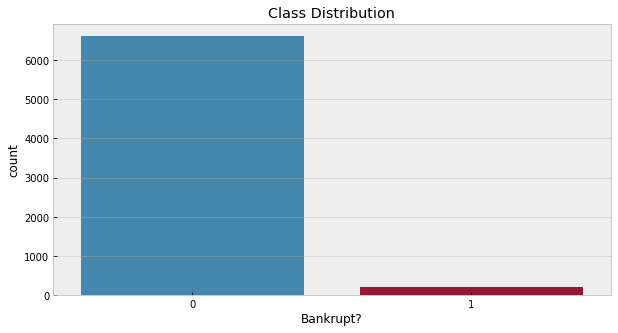

In [5]:
plt.figure(figsize = (10,5))
sns.countplot(data['Bankrupt?'])
plt.title('Class Distribution')
plt.show()

### Data distribution using boxplot (log scale)

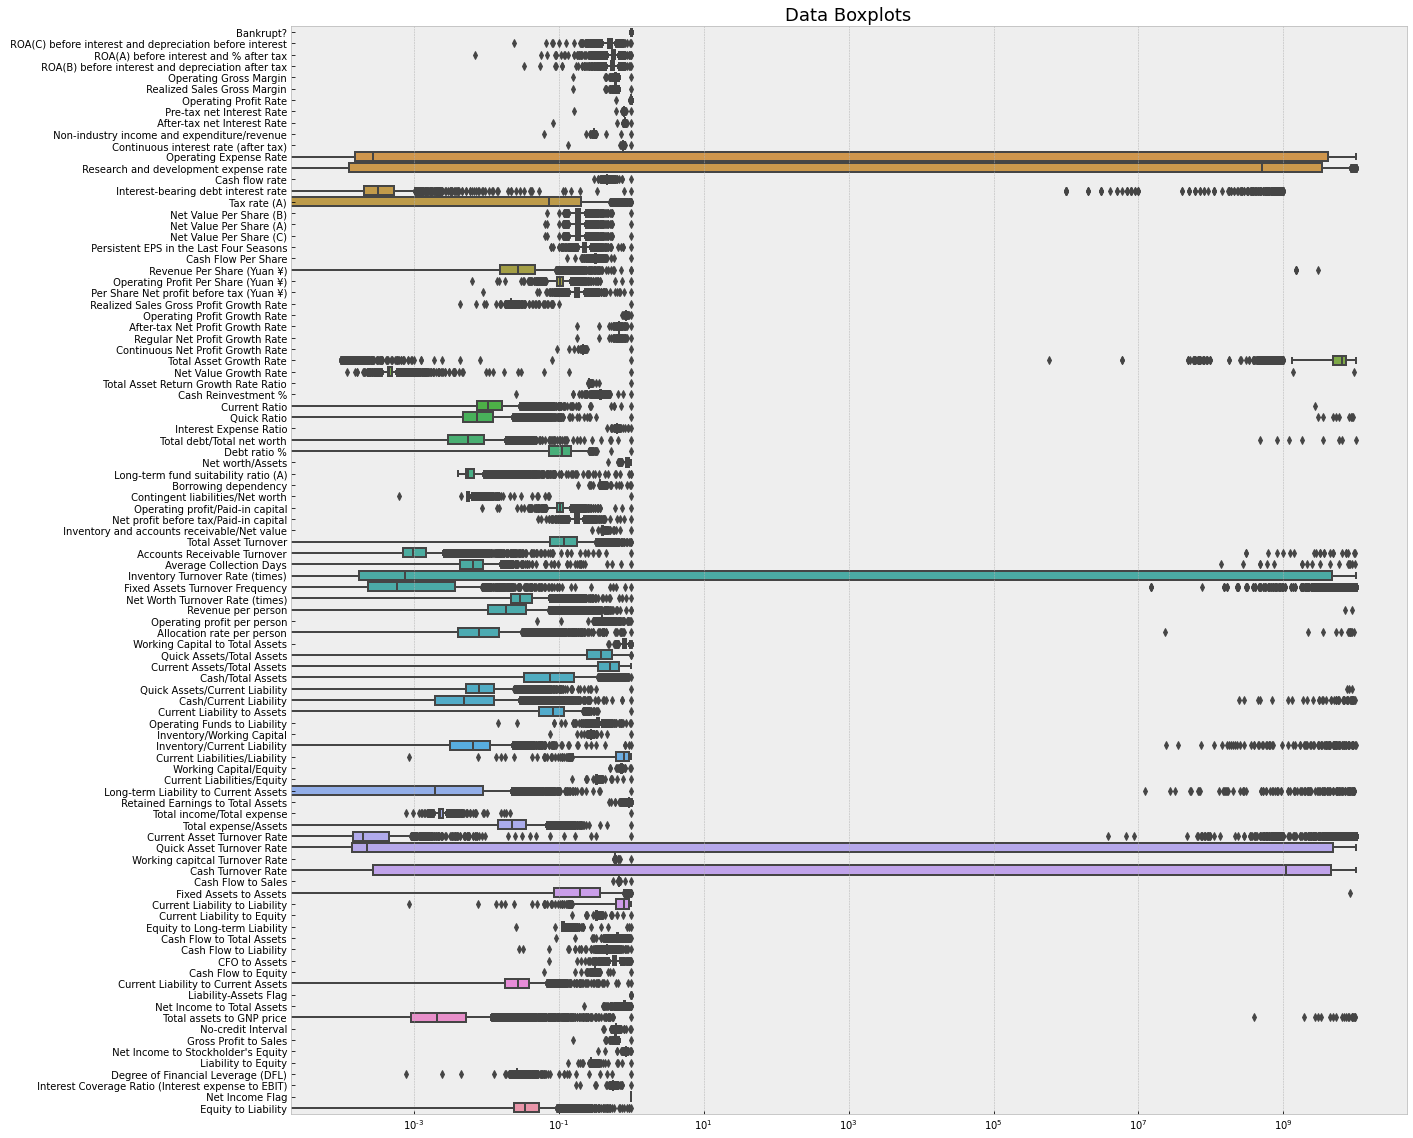

In [6]:
plt.figure(figsize = (20,20))
box = sns.boxplot(data = data, orient="h")
box.set_title('Data Boxplots', fontsize = 18)
box.set(xscale="log")
plt.show()

### Outlier removal

In [7]:
def outlier_removal(feature,feat_name,dataset):
    
    q_25, q_75 = np.percentile(feature, 25), np.percentile(feature, 75)
    iqr = q_75 - q_25
    cut_off = iqr * 20000000000000    # for minimal but effective removal, maintaining the class distribution ratio
    lower, upper = q_25 - cut_off, q_75 + cut_off
    dataset = dataset.drop(dataset[(dataset[feat_name] > upper) | (dataset[feat_name] < lower)].index)
    return dataset

out_rem_data = data

for column in data.iloc[:,1:]:
    out_rem_data = outlier_removal(data[column],str(column),out_rem_data)

In [8]:
out_rem_data.shape

(6000, 96)

### Distribution after outlier removal

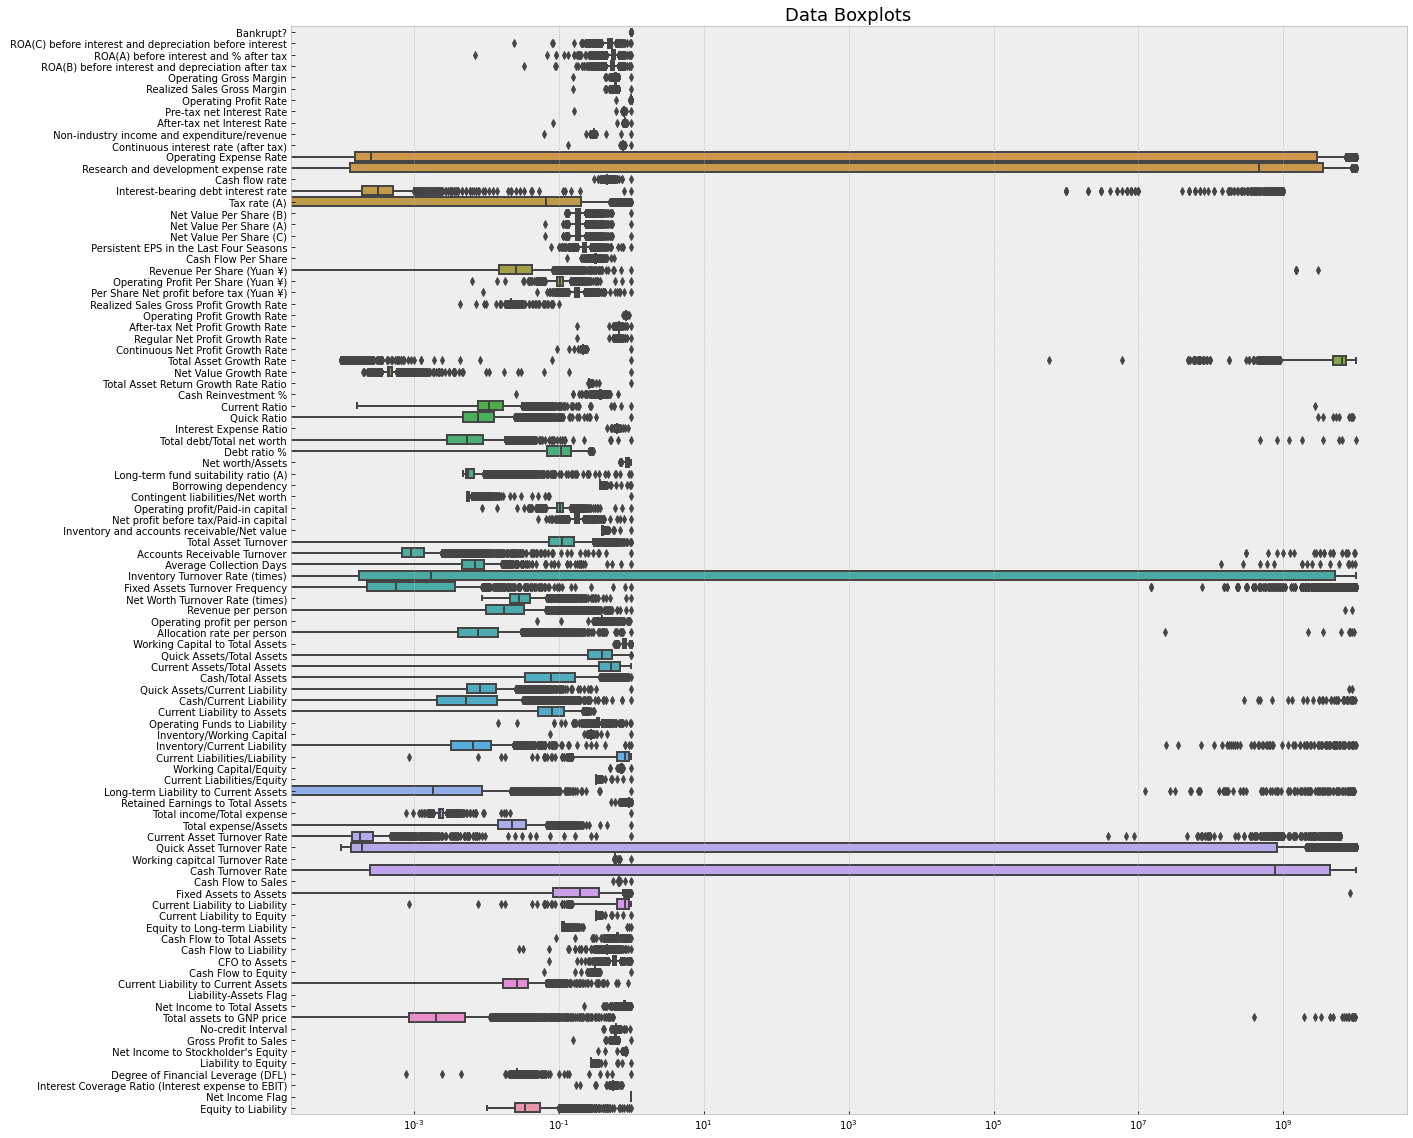

In [9]:
plt.figure(figsize = (20,20))
box = sns.boxplot(data = out_rem_data, orient="h")
box.set_title('Data Boxplots', fontsize = 18)
box.set(xscale="log")
plt.show()

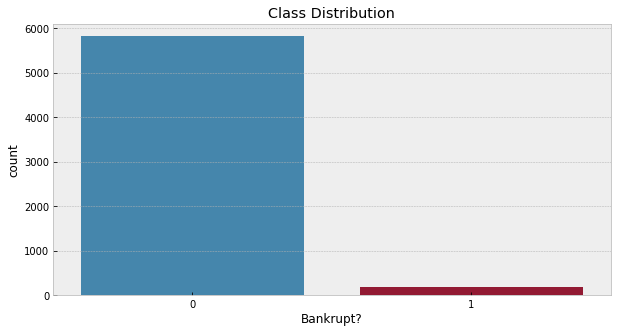

In [10]:
plt.figure(figsize = (10,5))
sns.countplot(out_rem_data['Bankrupt?'])
plt.title('Class Distribution')
plt.show()

### Boxplots for each feature

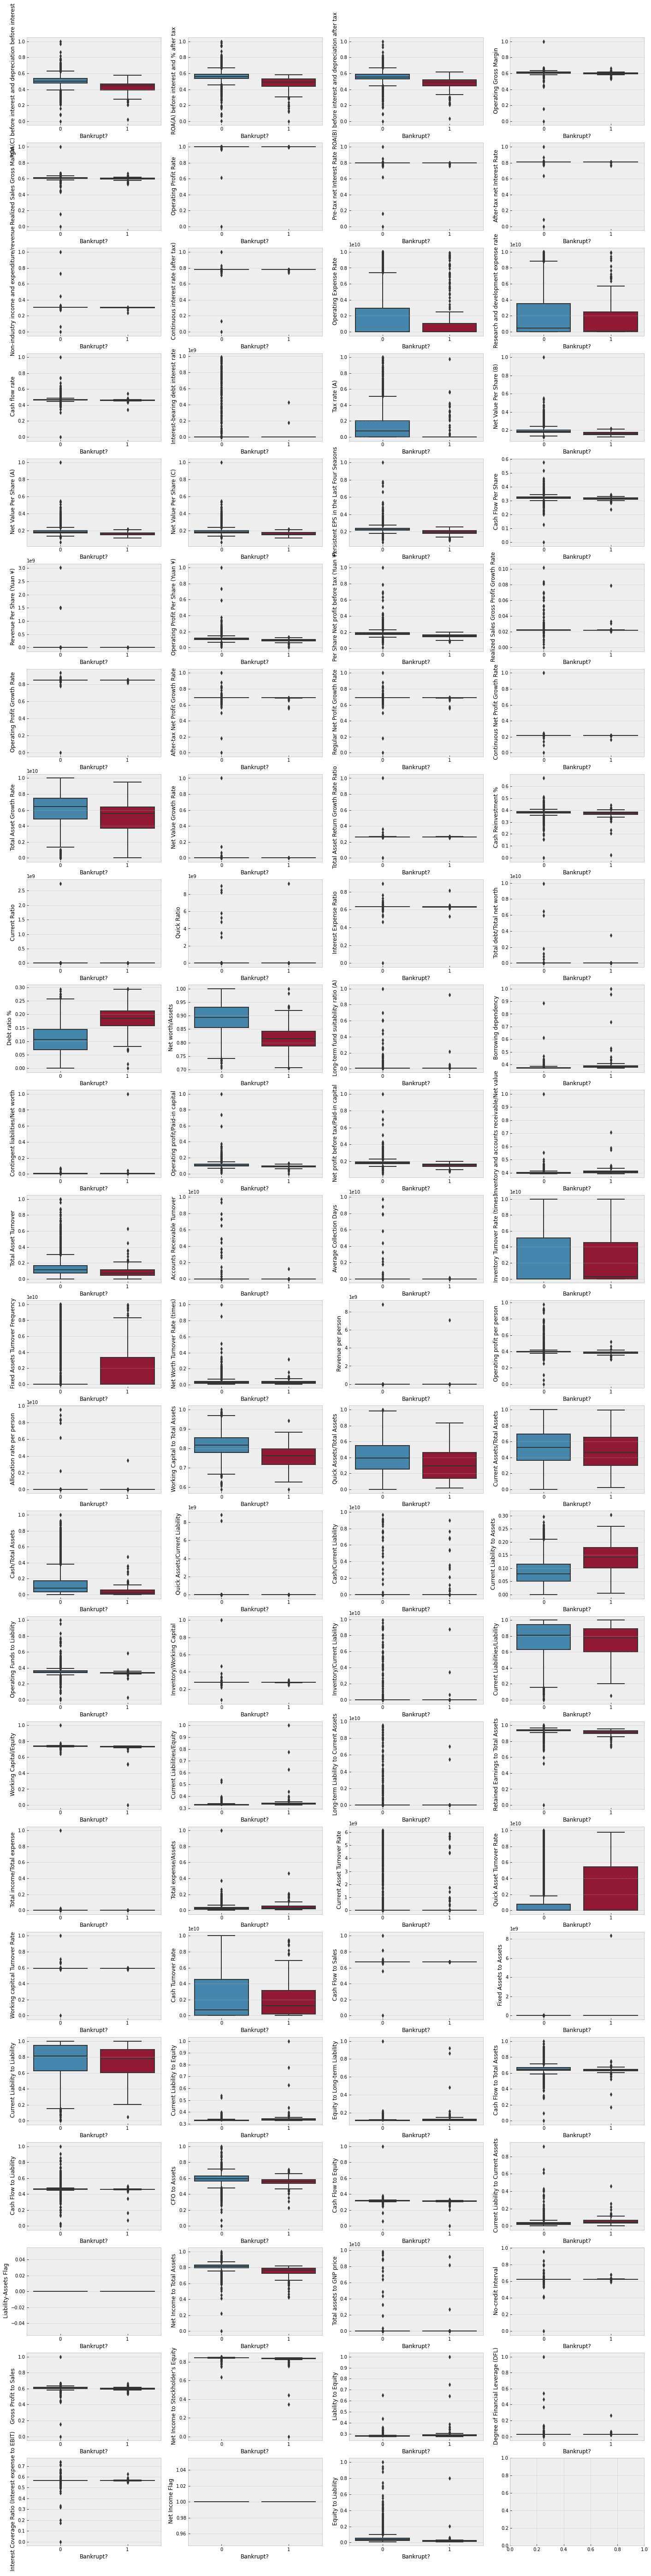

In [11]:
f, ax = plt.subplots(24, 4, figsize=(24,100))

for i in range(1, 96):

    sns.boxplot(x='Bankrupt?', y=out_rem_data.iloc[:,i].name, data=out_rem_data, ax=ax[int((i-1)/4)][(i-1)%4])
        
plt.show()


### Boxplots for features with significant difference in class-wise distributions

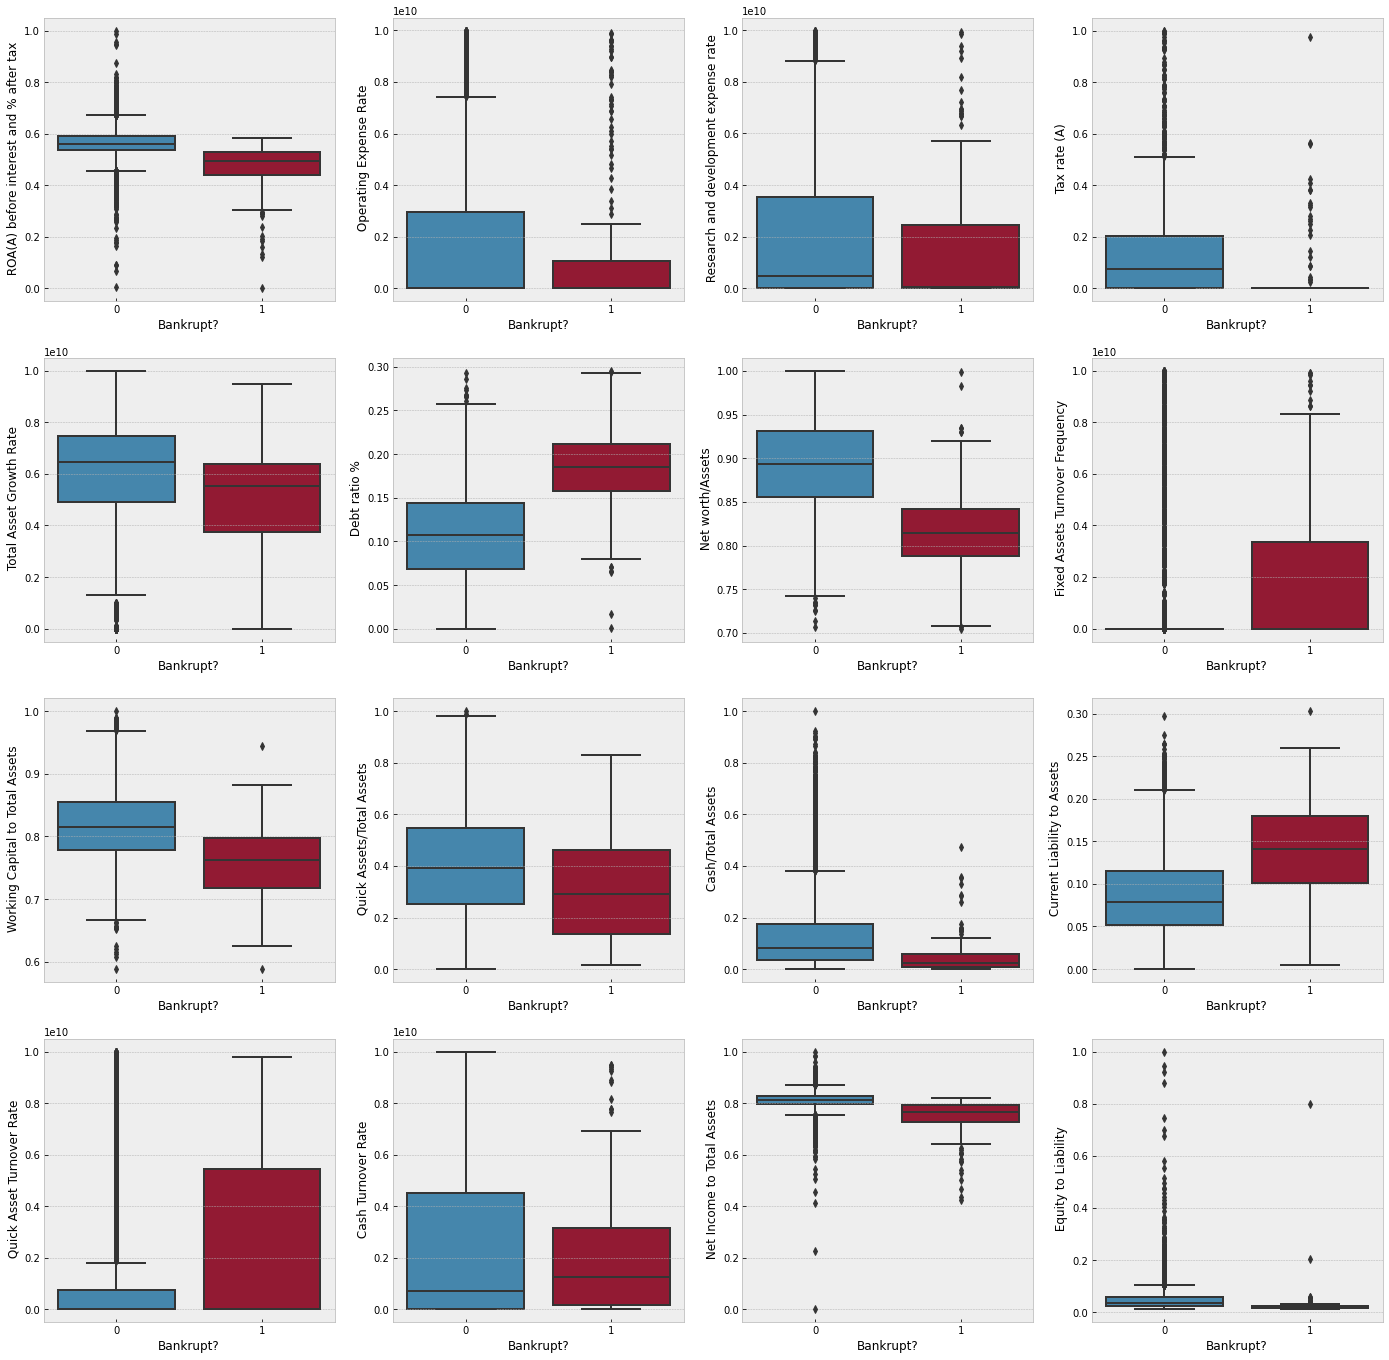

In [12]:
sgn_diff = [2, 11, 12, 15, 29, 37, 38, 49, 54, 55, 57, 60, 72, 74, 86, 95]
f, ax = plt.subplots(4, 4, figsize=(24,24))

for i in range(16):

    sns.boxplot(x='Bankrupt?', y=out_rem_data.iloc[:,sgn_diff[i]].name, data=out_rem_data, ax=ax[int(i/4)][i%4])
    
plt.show()

### Separating features and labels

In [13]:
labels = out_rem_data['Bankrupt?']
out_rem_data = out_rem_data.drop(['Bankrupt?'], axis = 1)

### Observing the skew in the distributions of all features

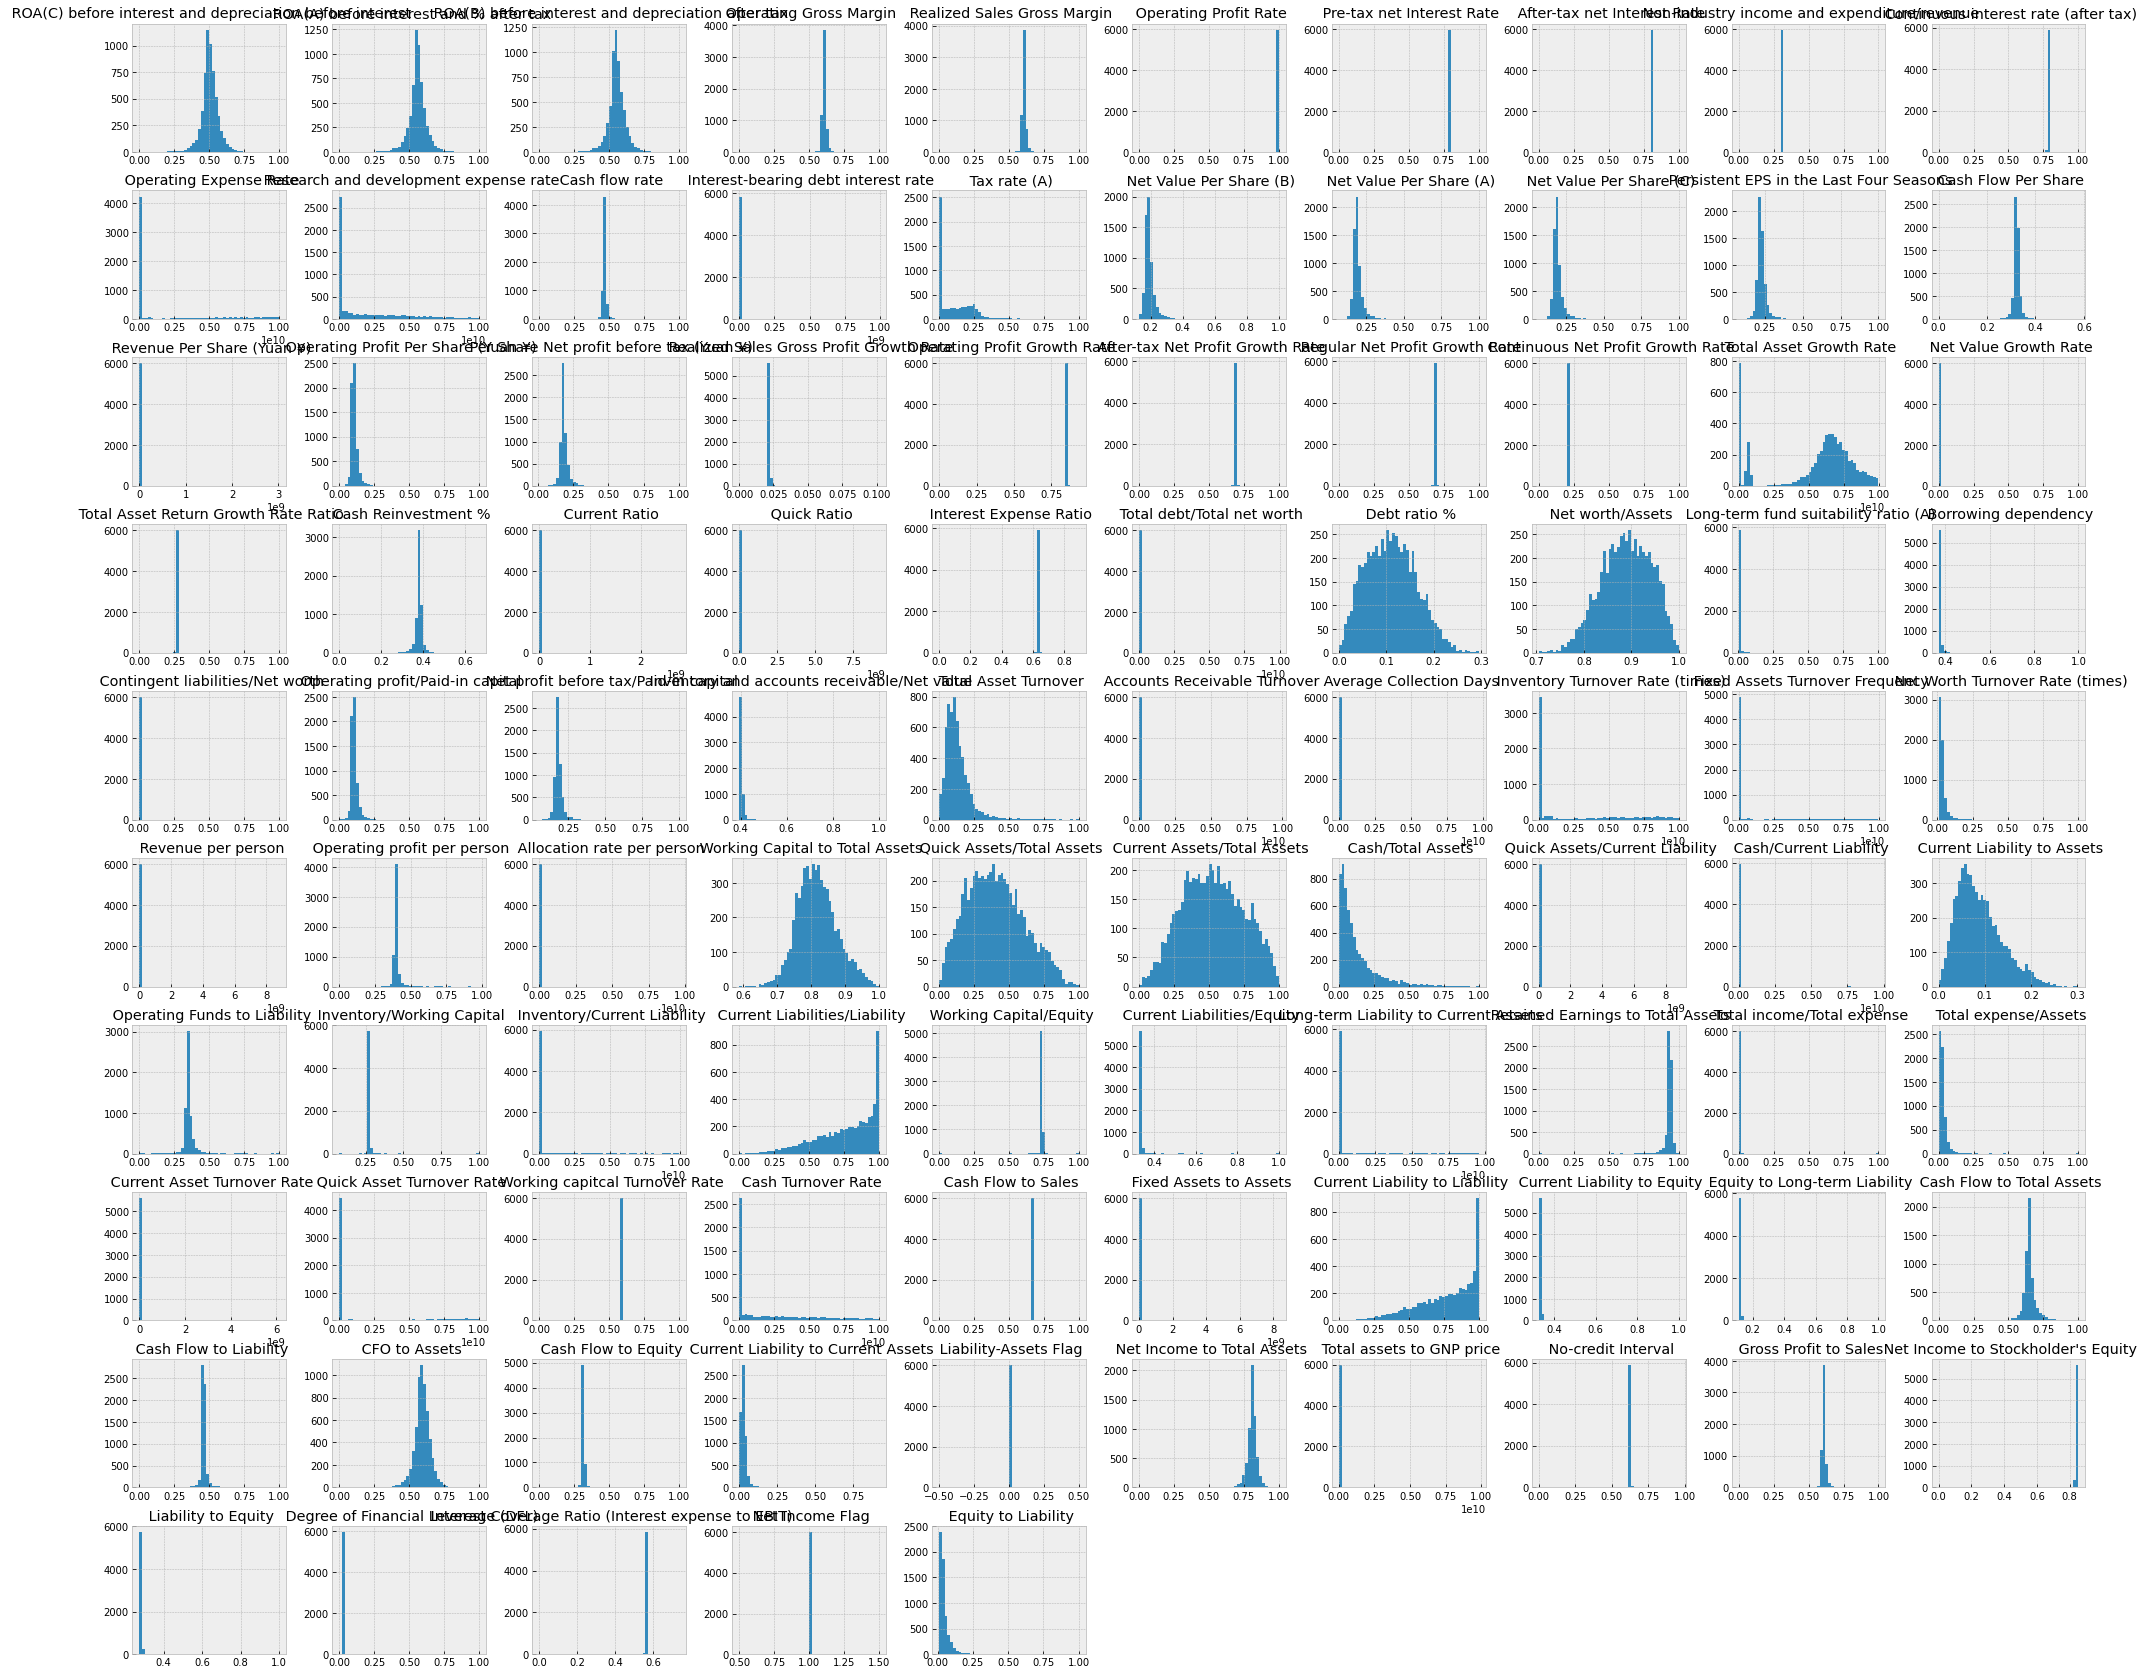

In [14]:
out_rem_data.hist(figsize = (35,30), bins = 50)
plt.show()

In [15]:
def logarithmic_transform(data):
    
    for column in data:
        skew = data[column].skew()
        if skew > 0.5 or skew < -0.5:
            data[column] = np.log1p(data[column])    # log1p(x) returns ln(1+x)
        else:
            continue
            
    return data

normalized_data = logarithmic_transform(out_rem_data)

## MODELING WITH ALL FEATURES

### Splitting training and testing data

In [16]:
x_raw,x_test,y_raw,y_test = train_test_split(normalized_data, labels, test_size=0.1, stratify=labels, random_state = 100)

### Stratified cross validation splitting

In [17]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=100)

for train, test in skf.split(x_raw,y_raw):
    
    print("Training set:", train, "Testing set:", test)    # prints indices of training and testing data
    x_train, x_val = x_raw.iloc[train], x_raw.iloc[test]
    y_train, y_val = y_raw.iloc[train], y_raw.iloc[test]

x_train = x_train.values
x_val = x_val.values
y_train = y_train.values
y_val = y_val.values

label_unique_train, label_counts_train = np.unique(y_train, return_counts=True)
label_unique_test, label_counts_test = np.unique(y_val, return_counts=True)

print('\nLabel Distributions: \n')
print("Training set: {}".format(label_counts_train/ len(y_train)))
print("Testing set:  {}".format(label_counts_test/ len(y_val)))

Training set: [   0    1    2 ... 5395 5396 5399] Testing set: [   6   12   18 ... 5394 5397 5398]
Training set: [   0    2    4 ... 5397 5398 5399] Testing set: [   1    3    7 ... 5388 5390 5396]
Training set: [   0    1    2 ... 5397 5398 5399] Testing set: [  20   25   28 ... 5384 5386 5392]
Training set: [   1    2    3 ... 5396 5397 5398] Testing set: [   0    8    9 ... 5389 5395 5399]
Training set: [   0    1    3 ... 5397 5398 5399] Testing set: [   2    4    5 ... 5381 5391 5393]

Label Distributions: 

Training set: [0.96944444 0.03055556]
Testing set:  [0.96851852 0.03148148]


### LOGISTIC REGRESSION with SMOTE

In [18]:
accuracy_list_LR = []

parameters_LR = {"penalty": ['l2',None], 'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000], 'class_weight': ['balanced',None], 
                 'solver':['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']}

randomfit_LR = RandomizedSearchCV(LogisticRegression(), parameters_LR)

for train, val in skf.split(x_train, y_train):
    pipeline_LR = make_pipeline(SMOTE(sampling_strategy='minority'), randomfit_LR)
    pipeline_LR.fit(x_train[train], y_train[train])
    best_estimator_LR = randomfit_LR.best_estimator_
    accuracy_list_LR.append(pipeline_LR.score(x_train[val], y_train[val]))

print("Overall Accuracy:\t\t {}".format(np.mean(accuracy_list_LR)))
print("\nThe best set of parameters:\t", randomfit_LR.best_params_)

Overall Accuracy:		 0.8680555555555557

The best set of parameters:	 {'solver': 'newton-cg', 'penalty': 'l2', 'class_weight': None, 'C': 1000}


In [19]:
label = ['Class 0', 'Class 1']
prediction_LR = best_estimator_LR.predict(x_val)
print(classification_report(y_val, prediction_LR, target_names=label))

              precision    recall  f1-score   support

     Class 0       0.99      0.91      0.95      1046
     Class 1       0.22      0.79      0.34        34

    accuracy                           0.90      1080
   macro avg       0.61      0.85      0.64      1080
weighted avg       0.97      0.90      0.93      1080



### RANDOM FOREST CLASSIFIER with SMOTE

In [20]:
accuracy_list_RFC = []

parameters_RFC = {'max_features' : ['auto', 'sqrt', 'log2'], 'random_state' : [100], 
                  'class_weight' : ['balanced','balanced_subsample'], 'criterion' : ['gini', 'entropy'], 
                  'bootstrap' : [True,False]}
    
randomfit_RFC = RandomizedSearchCV(RandomForestClassifier(), parameters_RFC)

for train, val in skf.split(x_train, y_train):
    pipeline_RFC = make_pipeline(SMOTE(sampling_strategy='minority'), randomfit_RFC) 
    pipeline_RFC.fit(x_train, y_train)
    best_estimator_RFC = randomfit_RFC.best_estimator_
    accuracy_list_RFC.append(pipeline_RFC.score(x_train[val], y_train[val]))
    
print("Overall Accuracy:\t\t {}".format(np.mean(accuracy_list_RFC)))
print("\nThe best set of parameters:\t", randomfit_RFC.best_params_)

Overall Accuracy:		 1.0

The best set of parameters:	 {'random_state': 100, 'max_features': 'auto', 'criterion': 'entropy', 'class_weight': 'balanced_subsample', 'bootstrap': False}


In [21]:
prediction_RFC = best_estimator_RFC.predict(x_val)
print(classification_report(y_val, prediction_RFC, target_names=label))

              precision    recall  f1-score   support

     Class 0       0.98      0.98      0.98      1046
     Class 1       0.31      0.32      0.31        34

    accuracy                           0.96      1080
   macro avg       0.64      0.65      0.65      1080
weighted avg       0.96      0.96      0.96      1080



### XGBOOST with SMOTE

In [22]:
accuracy_list_XGB = []

parameters_XGB = {'eta' : [0.1,0.01,0.001], 'eval_metric': ['logloss'], 'max_depth' : [3,6,9], 'lambda' : [1,1.5,2],
                  'alpha' : [0,0.5,1]}       
        
randomfit_XGB = RandomizedSearchCV(xgb.XGBClassifier(random_state = 100), parameters_XGB)

for train, val in skf.split(x_train, y_train):
    pipeline_XGB = make_pipeline(SMOTE(sampling_strategy='minority'), randomfit_XGB)
    pipeline_XGB.fit(x_train, y_train)
    best_estimator_XGB = randomfit_XGB.best_estimator_
    accuracy_list_XGB.append(pipeline_XGB.score(x_train[val], y_train[val]))

print("Overall Accuracy:\t\t {}".format(np.mean(accuracy_list_XGB)))
print("\nThe best set of parameters:\t", randomfit_XGB.best_params_)

Overall Accuracy:		 0.9997685185185186

The best set of parameters:	 {'max_depth': 9, 'lambda': 1.5, 'eval_metric': 'logloss', 'eta': 0.1, 'alpha': 0}


In [23]:
prediction_XGB = best_estimator_XGB.predict(x_val)
print(classification_report(y_val, prediction_XGB, target_names=label))

              precision    recall  f1-score   support

     Class 0       0.98      0.97      0.98      1046
     Class 1       0.33      0.38      0.35        34

    accuracy                           0.96      1080
   macro avg       0.65      0.68      0.66      1080
weighted avg       0.96      0.96      0.96      1080



### CATBOOST with SMOTE

In [24]:
accuracy_list_CTB = []

parameters_CTB = {'eval_metric': ['F1'], 'iterations': [100,500,1000], 'learning_rate' : [0.1,0.01,0.001], 
                  'random_seed' : [100], 'auto_class_weights' : ['Balanced','SqrtBalanced']}
    
randomfit_CTB = RandomizedSearchCV(CatBoostClassifier(verbose = 0), parameters_CTB)

for train, val in skf.split(x_train, y_train):
    pipeline_CTB = make_pipeline(SMOTE(sampling_strategy='minority'), randomfit_CTB) 
    pipeline_CTB.fit(x_train, y_train)
    best_estimator_CTB = randomfit_CTB.best_estimator_
    accuracy_list_CTB.append(pipeline_CTB.score(x_train[val], y_train[val]))
    
print("Overall Accuracy:\t\t {}".format(np.mean(accuracy_list_CTB)))
print("\nThe best set of parameters:\t", randomfit_CTB.best_params_)

Overall Accuracy:		 0.9979166666666668

The best set of parameters:	 {'random_seed': 100, 'learning_rate': 0.1, 'iterations': 1000, 'eval_metric': 'F1', 'auto_class_weights': 'Balanced'}


In [25]:
prediction_CTB = best_estimator_CTB.predict(x_val)
print(classification_report(y_val, prediction_CTB, target_names=label))

              precision    recall  f1-score   support

     Class 0       0.98      0.97      0.98      1046
     Class 1       0.35      0.47      0.40        34

    accuracy                           0.96      1080
   macro avg       0.67      0.72      0.69      1080
weighted avg       0.96      0.96      0.96      1080



### Confusion matrices for all four classifiers

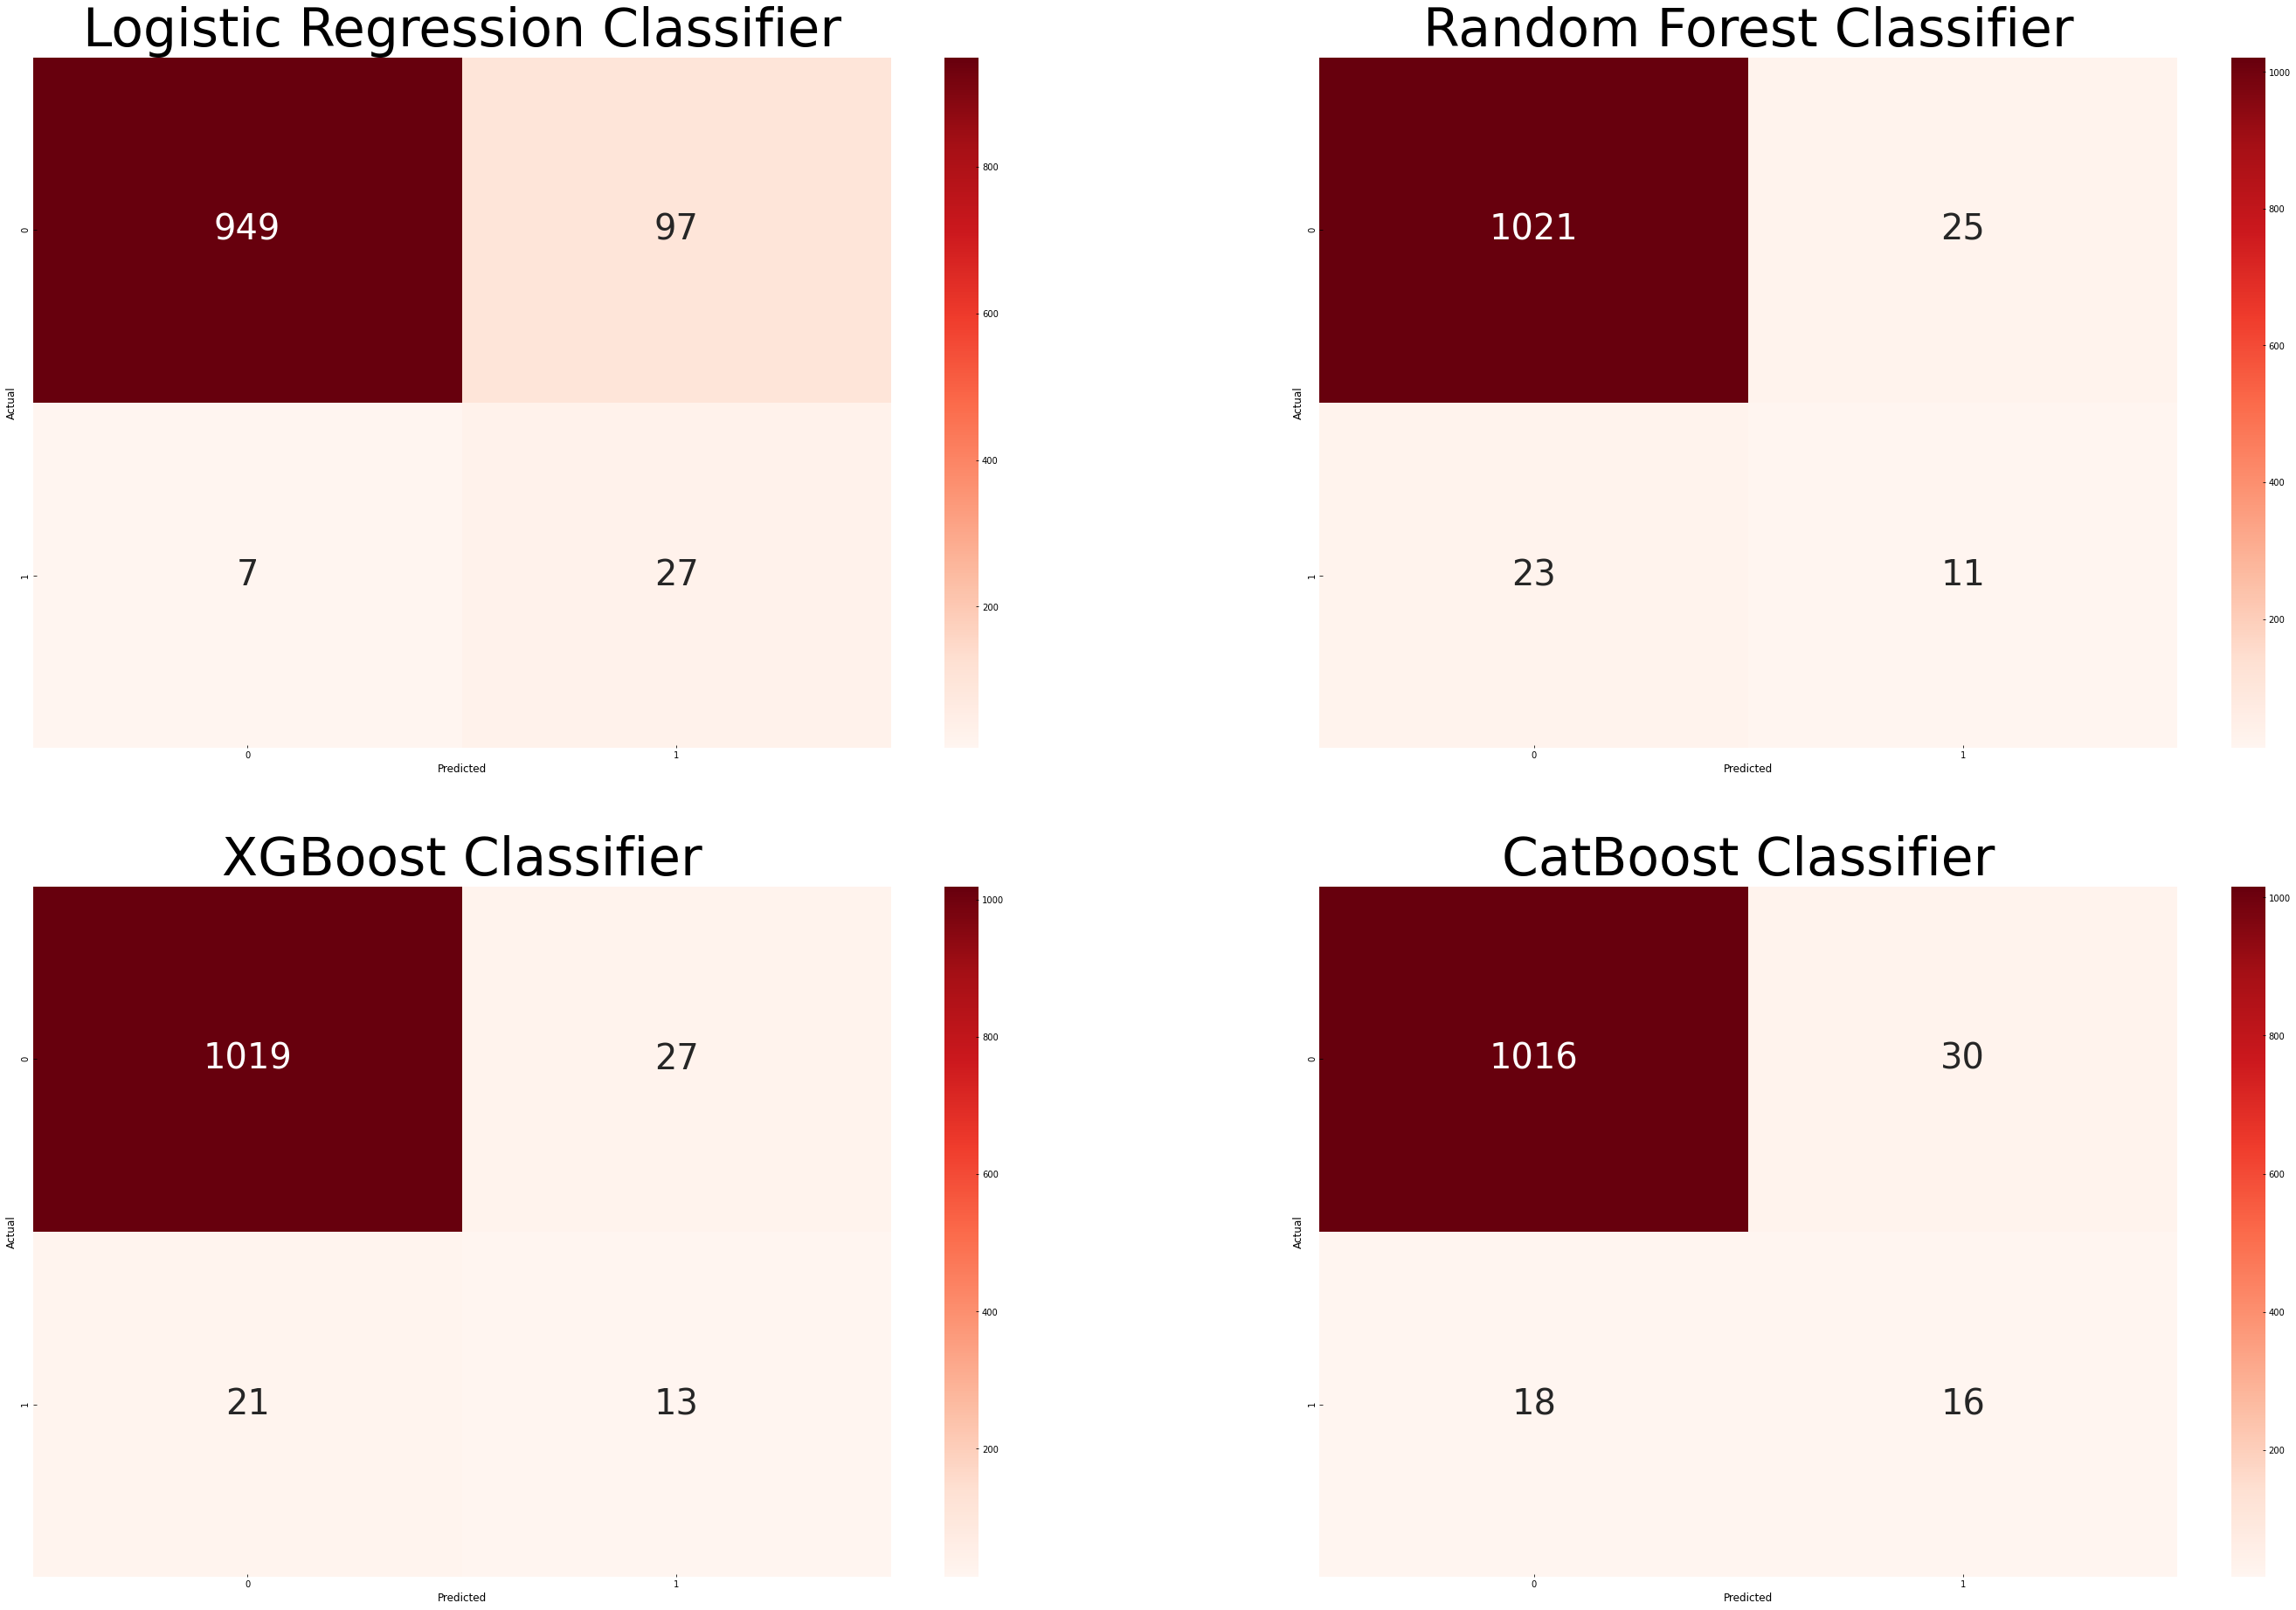

In [26]:
confusion_matrix_LR = confusion_matrix(y_val,prediction_LR)
confusion_matrix_RFC = confusion_matrix(y_val,prediction_RFC)
confusion_matrix_XGB = confusion_matrix(y_val,prediction_XGB)
confusion_matrix_CTB = confusion_matrix(y_val,prediction_CTB)

heat_confusion_matrix_LR = pd.DataFrame(confusion_matrix_LR, columns=np.unique(y_val), index = np.unique(y_val))
heat_confusion_matrix_LR.index.name = 'Actual'
heat_confusion_matrix_LR.columns.name = 'Predicted'

heat_confusion_matrix_RFC = pd.DataFrame(confusion_matrix_RFC, columns=np.unique(y_val), index = np.unique(y_val))
heat_confusion_matrix_RFC.index.name = 'Actual'
heat_confusion_matrix_RFC.columns.name = 'Predicted'

heat_confusion_matrix_XGB = pd.DataFrame(confusion_matrix_XGB, columns=np.unique(y_val), index = np.unique(y_val))
heat_confusion_matrix_XGB.index.name = 'Actual'
heat_confusion_matrix_XGB.columns.name = 'Predicted'

heat_confusion_matrix_CTB = pd.DataFrame(confusion_matrix_CTB, columns=np.unique(y_val), index = np.unique(y_val))
heat_confusion_matrix_CTB.index.name = 'Actual'
heat_confusion_matrix_CTB.columns.name = 'Predicted'

f, ax = plt.subplots(2, 2, figsize=(20,32))
f.subplots_adjust(left=None, bottom=None, right= 2, top=None, wspace=None, hspace= None)

sns.heatmap(heat_confusion_matrix_LR, cmap="Reds", annot=True, annot_kws={"size": 40},fmt='g', ax = ax[0][0])
ax[0][0].set_title('Logistic Regression Classifier', fontsize = 60)
sns.heatmap(heat_confusion_matrix_RFC, cmap="Reds", annot=True, annot_kws={"size": 40},fmt='g', ax = ax[0][1])
ax[0][1].set_title('Random Forest Classifier', fontsize = 60)
sns.heatmap(heat_confusion_matrix_XGB, cmap="Reds", annot=True, annot_kws={"size": 40},fmt='g', ax = ax[1][0])
ax[1][0].set_title('XGBoost Classifier', fontsize = 60)
sns.heatmap(heat_confusion_matrix_CTB, cmap="Reds", annot=True, annot_kws={"size": 40},fmt='g', ax = ax[1][1])
ax[1][1].set_title('CatBoost Classifier', fontsize = 60)

plt.show()

### Sensitivity values for all four classifiers

In [27]:
sens_LR = heat_confusion_matrix_LR.iloc[1,1]/heat_confusion_matrix_LR.iloc[1,:].sum()
sens_RFC = heat_confusion_matrix_RFC.iloc[1,1]/heat_confusion_matrix_RFC.iloc[1,:].sum()
sens_XGB = heat_confusion_matrix_XGB.iloc[1,1]/heat_confusion_matrix_XGB.iloc[1,:].sum()
sens_CTB = heat_confusion_matrix_CTB.iloc[1,1]/heat_confusion_matrix_CTB.iloc[1,:].sum()

print("Logistic Regression Classifier:\t\t{}".format(sens_LR))
print("Random Forest Classifier:\t\t{}".format(sens_RFC))
print("XGBoost Classifier:\t\t\t{}".format(sens_XGB))
print("CatBoost Classifier:\t\t\t{}".format(sens_CTB))

Logistic Regression Classifier:		0.7941176470588235
Random Forest Classifier:		0.3235294117647059
XGBoost Classifier:			0.38235294117647056
CatBoost Classifier:			0.47058823529411764


### Accuracy values for all four classifiers

In [28]:
acc_LR = (heat_confusion_matrix_LR.iloc[1,1]+heat_confusion_matrix_LR.iloc[0,0])/heat_confusion_matrix_LR.sum().sum()
acc_RFC = (heat_confusion_matrix_RFC.iloc[1,1]+heat_confusion_matrix_RFC.iloc[0,0])/heat_confusion_matrix_RFC.sum().sum()
acc_XGB = (heat_confusion_matrix_XGB.iloc[1,1]+heat_confusion_matrix_XGB.iloc[0,0])/heat_confusion_matrix_XGB.sum().sum()
acc_CTB = (heat_confusion_matrix_CTB.iloc[1,1]+heat_confusion_matrix_CTB.iloc[0,0])/heat_confusion_matrix_CTB.sum().sum()

print("Logistic Regression Classifier:\t\t{}".format(acc_LR))
print("Random Forest Classifier:\t\t{}".format(acc_RFC))
print("XGBoost Classifier:\t\t\t{}".format(acc_XGB))
print("CatBoost Classifier:\t\t\t{}".format(acc_CTB))

Logistic Regression Classifier:		0.9037037037037037
Random Forest Classifier:		0.9555555555555556
XGBoost Classifier:			0.9555555555555556
CatBoost Classifier:			0.9555555555555556


### Weighted metric

In [29]:
wt_met_LR = sens_LR**2 * acc_LR
wt_met_RFC = sens_RFC**2 * acc_RFC
wt_met_XGB = sens_XGB**2 * acc_XGB
wt_met_CTB = sens_CTB**2 * acc_CTB

print("Logistic Regression Classifier:\t\t{}".format(wt_met_LR))
print("Random Forest Classifier:\t\t{}".format(wt_met_RFC))
print("XGBoost Classifier:\t\t\t{}".format(wt_met_XGB))
print("CatBoost Classifier:\t\t\t{}".format(wt_met_CTB))

Logistic Regression Classifier:		0.5698961937716263
Random Forest Classifier:		0.10001922337562477
XGBoost Classifier:			0.1396962706651288
CatBoost Classifier:			0.2116109188773549


### TESTING

In [30]:
test_prediction_LR = best_estimator_LR.predict(x_test)
test_prediction_CTB = best_estimator_CTB.predict(x_test)

### Confusion matrices for Logistic Regression and XGBoost Classifiers

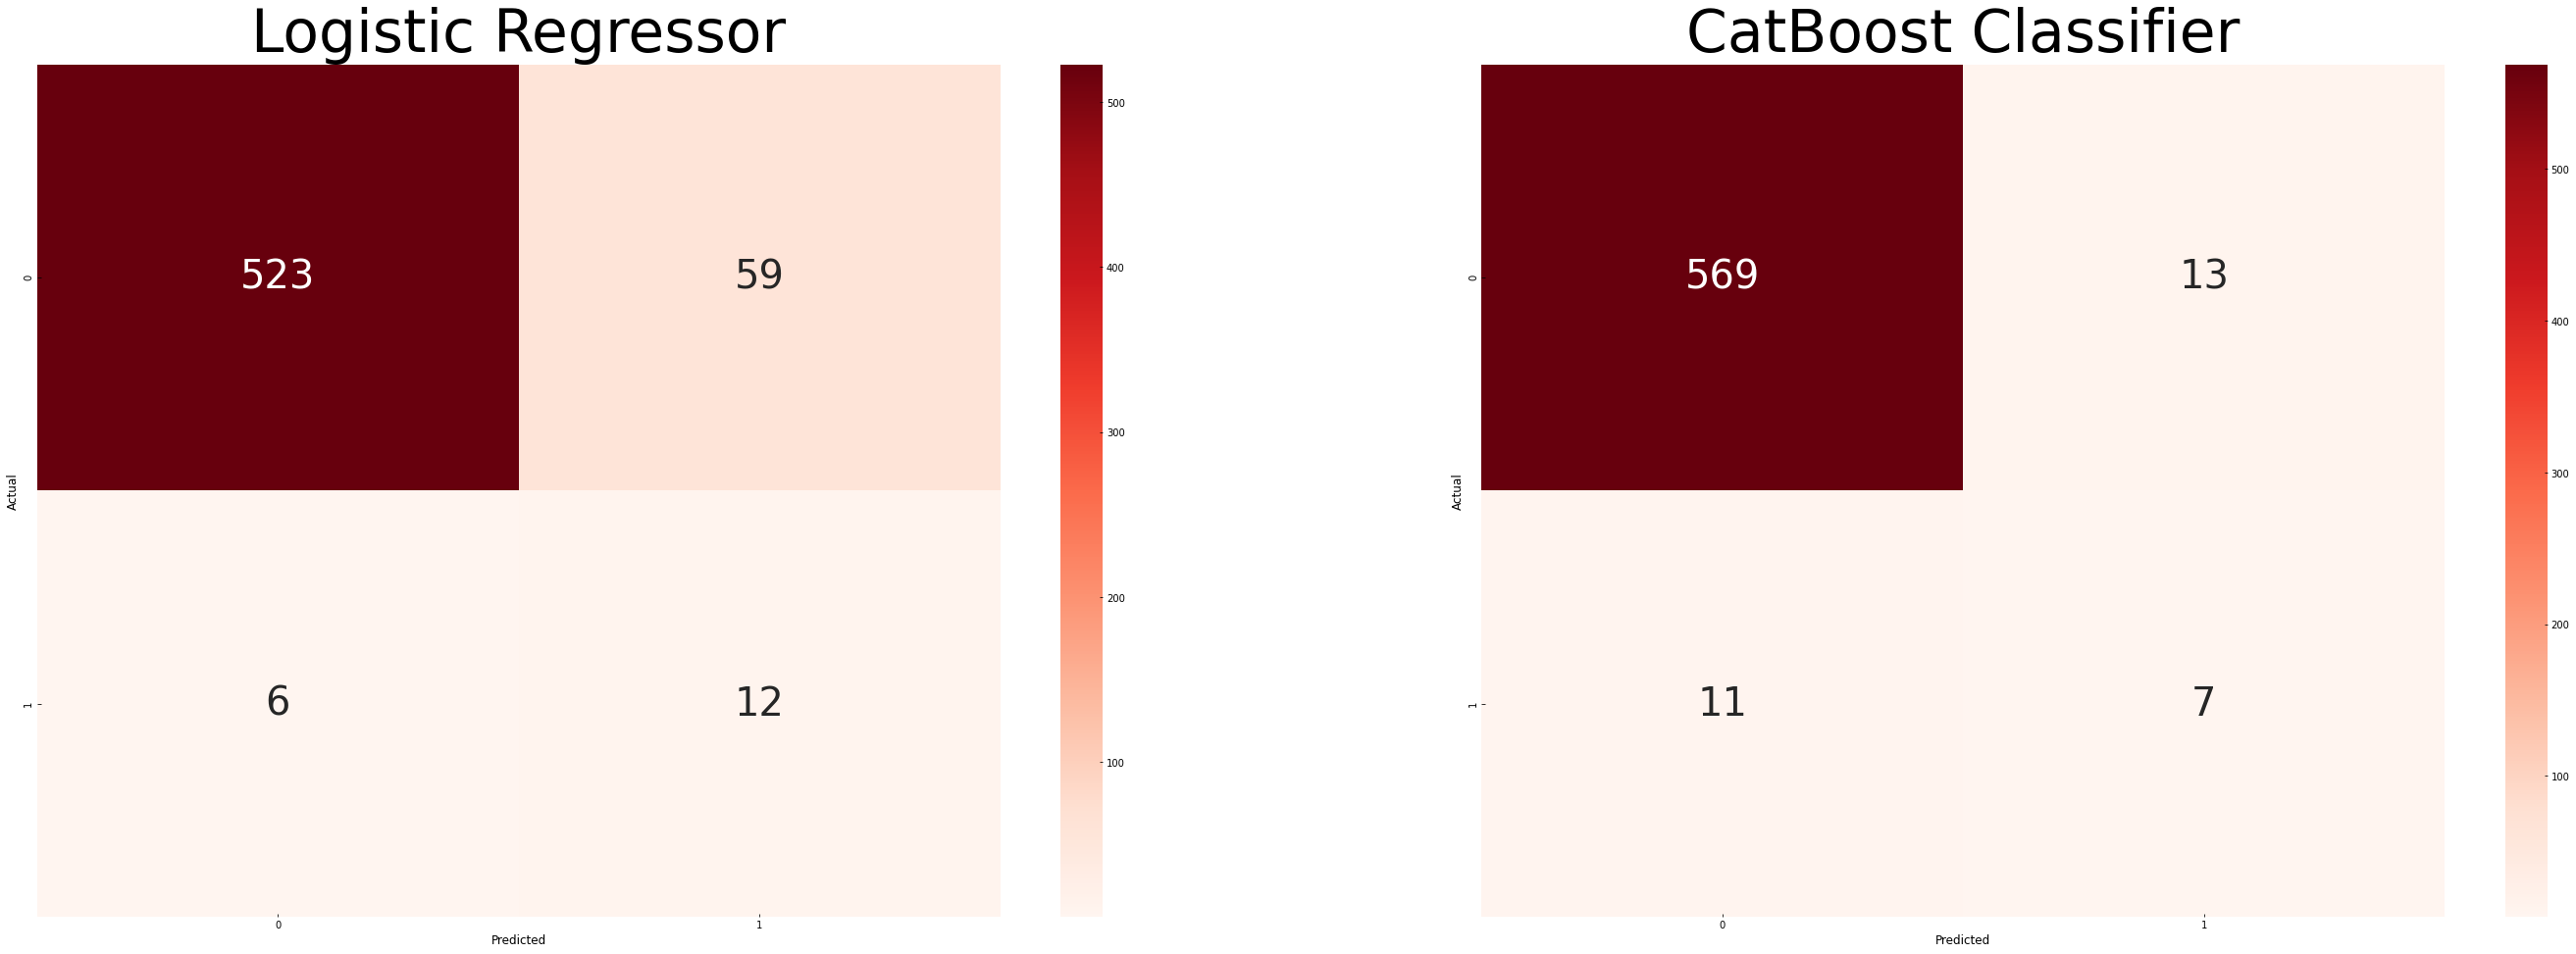

In [31]:
confusion_matrix_LR = confusion_matrix(y_test,test_prediction_LR)
confusion_matrix_CTB = confusion_matrix(y_test,test_prediction_CTB)

heat_confusion_matrix_LR = pd.DataFrame(confusion_matrix_LR, columns=np.unique(y_test), index = np.unique(y_test))
heat_confusion_matrix_LR.index.name = 'Actual'
heat_confusion_matrix_LR.columns.name = 'Predicted'

heat_confusion_matrix_CTB = pd.DataFrame(confusion_matrix_CTB, columns=np.unique(y_test), index = np.unique(y_test))
heat_confusion_matrix_CTB.index.name = 'Actual'
heat_confusion_matrix_CTB.columns.name = 'Predicted'

f, ax = plt.subplots(1, 2, figsize=(20,16))
f.subplots_adjust(left=None, bottom=None, right= 2, top=None, wspace=None, hspace= None)

sns.heatmap(heat_confusion_matrix_LR, cmap="Reds", annot=True, annot_kws={"size": 40},fmt='g', ax = ax[0])
ax[0].set_title('Logistic Regressor', fontsize = 60)
sns.heatmap(heat_confusion_matrix_CTB, cmap="Reds", annot=True, annot_kws={"size": 40},fmt='g', ax = ax[1])
ax[1].set_title('CatBoost Classifier', fontsize = 60)

plt.show()

In [32]:
print('Logistic Regression report:\n')
print(classification_report(y_test, test_prediction_LR, target_names=label))

Logistic Regression report:

              precision    recall  f1-score   support

     Class 0       0.99      0.90      0.94       582
     Class 1       0.17      0.67      0.27        18

    accuracy                           0.89       600
   macro avg       0.58      0.78      0.61       600
weighted avg       0.96      0.89      0.92       600



In [33]:
print('CatBoost report:\n')
print(classification_report(y_test, test_prediction_CTB, target_names=label))

CatBoost report:

              precision    recall  f1-score   support

     Class 0       0.98      0.98      0.98       582
     Class 1       0.35      0.39      0.37        18

    accuracy                           0.96       600
   macro avg       0.67      0.68      0.67       600
weighted avg       0.96      0.96      0.96       600



## MODELING WITH 16 FEATURES (SIGNIFICANT DIFFERENCE)

In [34]:
sgn_diff_data = normalized_data.iloc[:,[x-1 for x in sgn_diff]]
sgn_diff_data.head()

,ROA(A) before interest and % after tax,Operating Expense Rate,Research and development expense rate,Tax rate (A),Total Asset Growth Rate,Debt ratio %,Net worth/Assets,Fixed Assets Turnover Frequency,Working Capital to Total Assets,Quick Assets/Total Assets,Cash/Total Assets,Current Liability to Assets,Quick Asset Turnover Rate,Cash Turnover Rate,Net Income to Total Assets,Equity to Liability
0,0.353743,0.000126,0.000000,0.000000,22.328696,0.207576,0.792424,0.000116,0.672775,0.166673,0.004086,0.137419,22.602731,19.942380,0.540489,0.016335
1,0.430622,0.000290,0.000000,0.000000,22.533193,0.171176,0.828824,20.393372,0.751111,0.127236,0.014837,0.055400,22.764486,21.635549,0.585171,0.020581
2,0.404811,0.000236,17.054189,0.000000,22.708397,0.207516,0.792484,21.697825,0.829502,0.340201,0.000990,0.093638,0.001022,20.450144,0.573614,0.016340
6,0.368597,0.000398,20.408555,0.000000,22.467235,0.216102,0.783898,0.000145,0.729416,0.255093,0.022728,0.109680,22.980854,21.594559,0.551940,0.015542
8,0.435113,0.000169,0.000000,0.005854,22.653337,0.058591,0.941409,0.000246,0.813738,0.378625,0.135570,0.056437,23.009722,0.000105,0.589811,0.063751


### Splitting Training and testing data

In [35]:
x_raw,x_test,y_raw,y_test = train_test_split(sgn_diff_data, labels, test_size=0.1, stratify=labels, random_state = 100)

### Stratified Cross Validation Splitting

In [36]:
for train, test in skf.split(x_raw,y_raw):
    
    print("Training set:", train, "Testing set:", test)    # prints indices of training and testing data
    x_train, x_val = x_raw.iloc[train], x_raw.iloc[test]
    y_train, y_val = y_raw.iloc[train], y_raw.iloc[test]

x_train = x_train.values
x_val = x_val.values
y_train = y_train.values
y_val = y_val.values

label_unique_train, label_counts_train = np.unique(y_train, return_counts=True)
label_unique_test, label_counts_test = np.unique(y_val, return_counts=True)

print('\nLabel Distributions: \n')
print("Training set: {}".format(label_counts_train/ len(y_train)))
print("Testing set:  {}".format(label_counts_test/ len(y_val)))

Training set: [   0    1    2 ... 5395 5396 5399] Testing set: [   6   12   18 ... 5394 5397 5398]
Training set: [   0    2    4 ... 5397 5398 5399] Testing set: [   1    3    7 ... 5388 5390 5396]
Training set: [   0    1    2 ... 5397 5398 5399] Testing set: [  20   25   28 ... 5384 5386 5392]
Training set: [   1    2    3 ... 5396 5397 5398] Testing set: [   0    8    9 ... 5389 5395 5399]
Training set: [   0    1    3 ... 5397 5398 5399] Testing set: [   2    4    5 ... 5381 5391 5393]

Label Distributions: 

Training set: [0.96944444 0.03055556]
Testing set:  [0.96851852 0.03148148]


### LOGISTIC REGRESSION with SMOTE

In [37]:
accuracy_list_LR = []

parameters_LR = {"penalty": ['l2',None], 'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000], 'class_weight': ['balanced',None], 
                 'solver':['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']}

randomfit_LR = RandomizedSearchCV(LogisticRegression(), parameters_LR)

for train, val in skf.split(x_train, y_train):
    pipeline_LR = make_pipeline(SMOTE(sampling_strategy='minority'), randomfit_LR)
    pipeline_LR.fit(x_train[train], y_train[train])
    best_estimator_LR = randomfit_LR.best_estimator_
    accuracy_list_LR.append(pipeline_LR.score(x_train[val], y_train[val]))

print("Overall Accuracy:\t\t {}".format(np.mean(accuracy_list_LR)))
print("\nThe best set of parameters:\t", randomfit_LR.best_params_)

Overall Accuracy:		 0.8354166666666666

The best set of parameters:	 {'solver': 'lbfgs', 'penalty': 'l2', 'class_weight': None, 'C': 1000}


In [38]:
label = ['Class 0', 'Class 1']
prediction_LR = best_estimator_LR.predict(x_val)
print(classification_report(y_val, prediction_LR, target_names=label))

              precision    recall  f1-score   support

     Class 0       0.99      0.85      0.92      1046
     Class 1       0.15      0.79      0.25        34

    accuracy                           0.85      1080
   macro avg       0.57      0.82      0.59      1080
weighted avg       0.97      0.85      0.90      1080



### RANDOM FOREST CLASSIFIER with SMOTE

In [39]:
accuracy_list_RFC = []

parameters_RFC = {'max_features' : ['auto', 'sqrt', 'log2'], 'random_state' : [100], 
                  'class_weight' : ['balanced','balanced_subsample'], 'criterion' : ['gini', 'entropy'], 
                  'bootstrap' : [True,False]}
    
randomfit_RFC = RandomizedSearchCV(RandomForestClassifier(), parameters_RFC)

for train, val in skf.split(x_train, y_train):
    pipeline_RFC = make_pipeline(SMOTE(sampling_strategy='minority'), randomfit_RFC) 
    pipeline_RFC.fit(x_train, y_train)
    best_estimator_RFC = randomfit_RFC.best_estimator_
    accuracy_list_RFC.append(pipeline_RFC.score(x_train[val], y_train[val]))
    
print("Overall Accuracy:\t\t {}".format(np.mean(accuracy_list_RFC)))
print("\nThe best set of parameters:\t", randomfit_RFC.best_params_)

Overall Accuracy:		 1.0

The best set of parameters:	 {'random_state': 100, 'max_features': 'sqrt', 'criterion': 'gini', 'class_weight': 'balanced', 'bootstrap': False}


In [40]:
prediction_RFC = best_estimator_RFC.predict(x_val)
print(classification_report(y_val, prediction_RFC, target_names=label))

              precision    recall  f1-score   support

     Class 0       0.98      0.97      0.98      1046
     Class 1       0.35      0.47      0.40        34

    accuracy                           0.96      1080
   macro avg       0.67      0.72      0.69      1080
weighted avg       0.96      0.96      0.96      1080



### XGBOOST with SMOTE

In [41]:
accuracy_list_XGB = []

parameters_XGB = {'eta' : [0.1,0.01,0.001], 'eval_metric': ['logloss'], 'max_depth' : [3,6,9], 'lambda' : [1,1.5,2],
                  'alpha' : [0,0.5,1]}       
        
randomfit_XGB = RandomizedSearchCV(xgb.XGBClassifier(random_state = 100), parameters_XGB)

for train, val in skf.split(x_train, y_train):
    pipeline_XGB = make_pipeline(SMOTE(sampling_strategy='minority'), randomfit_XGB)
    pipeline_XGB.fit(x_train, y_train)
    best_estimator_XGB = randomfit_XGB.best_estimator_
    accuracy_list_XGB.append(pipeline_XGB.score(x_train[val], y_train[val]))

print("Overall Accuracy:\t\t {}".format(np.mean(accuracy_list_XGB)))
print("\nThe best set of parameters:\t", randomfit_XGB.best_params_)

Overall Accuracy:		 0.999537037037037

The best set of parameters:	 {'max_depth': 9, 'lambda': 2, 'eval_metric': 'logloss', 'eta': 0.1, 'alpha': 0.5}


In [42]:
prediction_XGB = best_estimator_XGB.predict(x_val)
print(classification_report(y_val, prediction_XGB, target_names=label))

              precision    recall  f1-score   support

     Class 0       0.99      0.96      0.97      1046
     Class 1       0.35      0.65      0.45        34

    accuracy                           0.95      1080
   macro avg       0.67      0.80      0.71      1080
weighted avg       0.97      0.95      0.96      1080



### CATBOOST with SMOTE

In [43]:
accuracy_list_CTB = []

parameters_CTB = {'eval_metric': ['F1'], 'iterations': [100,500,1000], 'learning_rate' : [0.1,0.01,0.001], 
                  'random_seed' : [100], 'auto_class_weights' : ['Balanced','SqrtBalanced']}
    
randomfit_CTB = RandomizedSearchCV(CatBoostClassifier(verbose = 0), parameters_CTB)

for train, val in skf.split(x_train, y_train):
    pipeline_CTB = make_pipeline(SMOTE(sampling_strategy='minority'), randomfit_CTB) 
    pipeline_CTB.fit(x_train, y_train)
    best_estimator_CTB = randomfit_CTB.best_estimator_
    accuracy_list_CTB.append(pipeline_CTB.score(x_train[val], y_train[val]))
    
print("Overall Accuracy:\t\t {}".format(np.mean(accuracy_list_CTB)))
print("\nThe best set of parameters:\t", randomfit_CTB.best_params_)

Overall Accuracy:		 1.0

The best set of parameters:	 {'random_seed': 100, 'learning_rate': 0.1, 'iterations': 500, 'eval_metric': 'F1', 'auto_class_weights': 'SqrtBalanced'}


In [44]:
prediction_CTB = best_estimator_CTB.predict(x_val)
print(classification_report(y_val, prediction_CTB, target_names=label))

              precision    recall  f1-score   support

     Class 0       0.98      0.97      0.97      1046
     Class 1       0.31      0.47      0.37        34

    accuracy                           0.95      1080
   macro avg       0.65      0.72      0.67      1080
weighted avg       0.96      0.95      0.96      1080



### Confusion matrices for all four classifiers

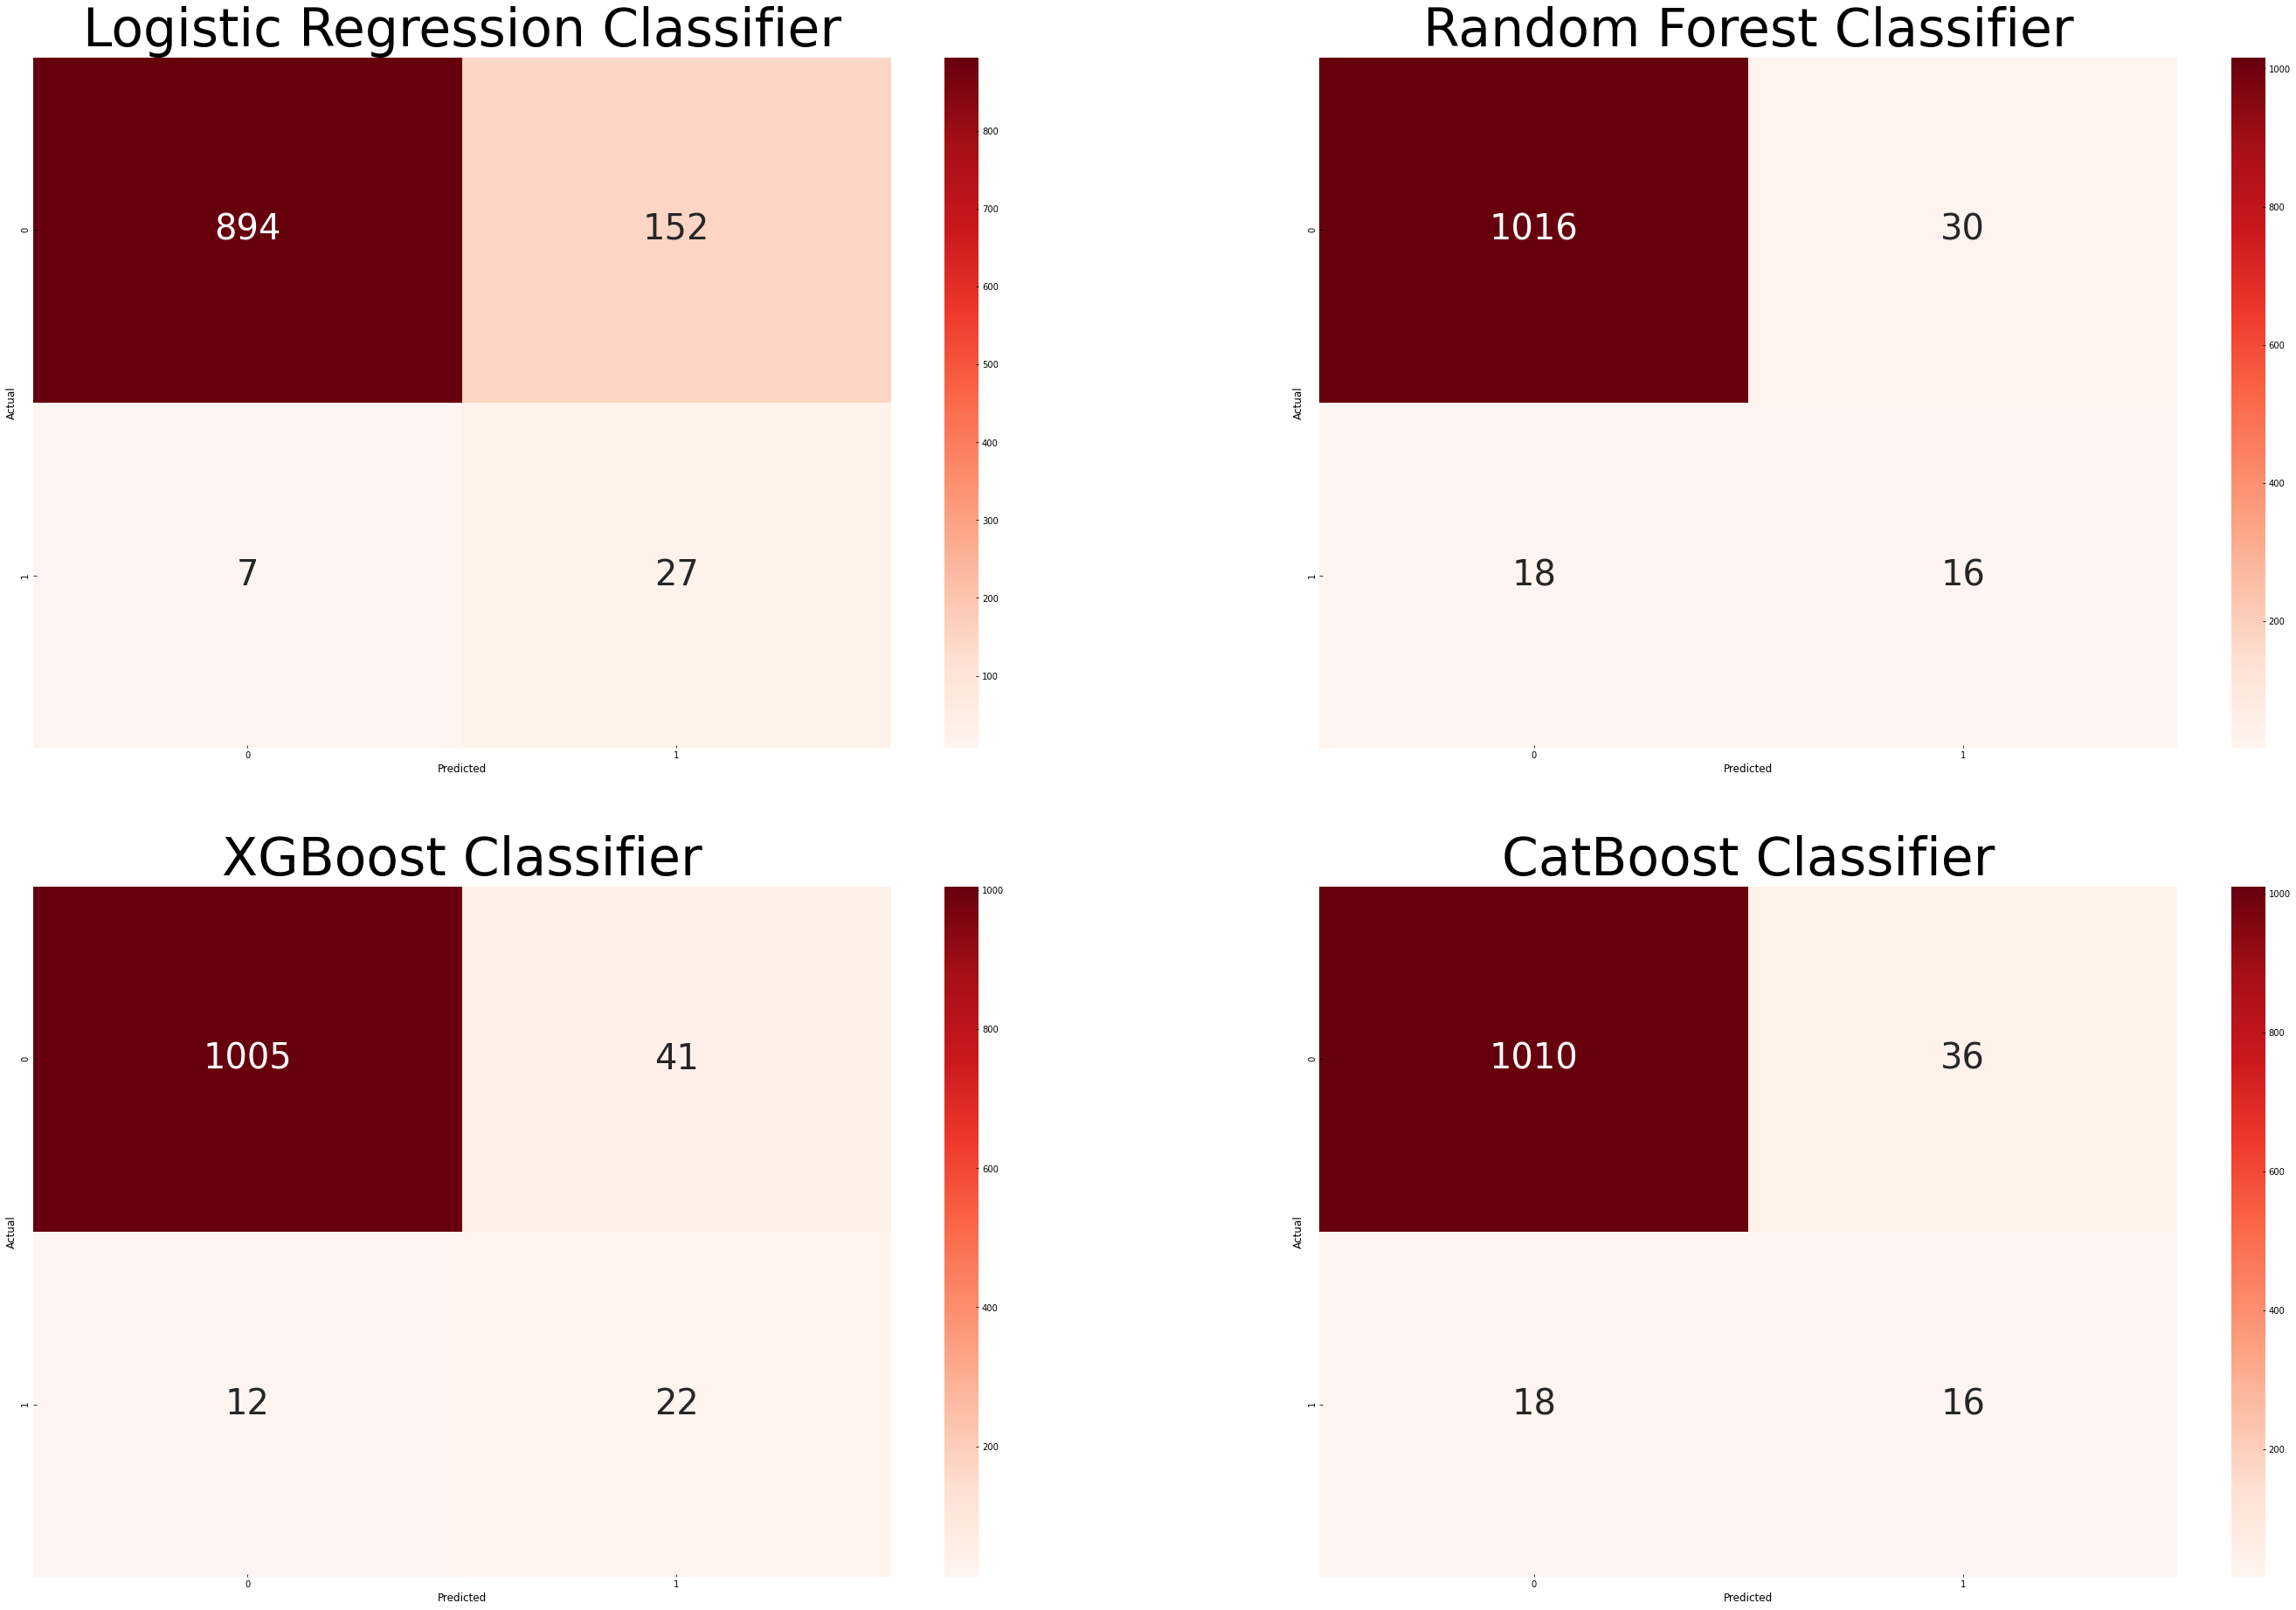

In [45]:
confusion_matrix_LR = confusion_matrix(y_val,prediction_LR)
confusion_matrix_RFC = confusion_matrix(y_val,prediction_RFC)
confusion_matrix_XGB = confusion_matrix(y_val,prediction_XGB)
confusion_matrix_CTB = confusion_matrix(y_val,prediction_CTB)

heat_confusion_matrix_LR = pd.DataFrame(confusion_matrix_LR, columns=np.unique(y_val), index = np.unique(y_val))
heat_confusion_matrix_LR.index.name = 'Actual'
heat_confusion_matrix_LR.columns.name = 'Predicted'

heat_confusion_matrix_RFC = pd.DataFrame(confusion_matrix_RFC, columns=np.unique(y_val), index = np.unique(y_val))
heat_confusion_matrix_RFC.index.name = 'Actual'
heat_confusion_matrix_RFC.columns.name = 'Predicted'

heat_confusion_matrix_XGB = pd.DataFrame(confusion_matrix_XGB, columns=np.unique(y_val), index = np.unique(y_val))
heat_confusion_matrix_XGB.index.name = 'Actual'
heat_confusion_matrix_XGB.columns.name = 'Predicted'

heat_confusion_matrix_CTB = pd.DataFrame(confusion_matrix_CTB, columns=np.unique(y_val), index = np.unique(y_val))
heat_confusion_matrix_CTB.index.name = 'Actual'
heat_confusion_matrix_CTB.columns.name = 'Predicted'

f, ax = plt.subplots(2, 2, figsize=(20,32))
f.subplots_adjust(left=None, bottom=None, right= 2, top=None, wspace=None, hspace= None)

sns.heatmap(heat_confusion_matrix_LR, cmap="Reds", annot=True, annot_kws={"size": 40},fmt='g', ax = ax[0][0])
ax[0][0].set_title('Logistic Regression Classifier', fontsize = 60)
sns.heatmap(heat_confusion_matrix_RFC, cmap="Reds", annot=True, annot_kws={"size": 40},fmt='g', ax = ax[0][1])
ax[0][1].set_title('Random Forest Classifier', fontsize = 60)
sns.heatmap(heat_confusion_matrix_XGB, cmap="Reds", annot=True, annot_kws={"size": 40},fmt='g', ax = ax[1][0])
ax[1][0].set_title('XGBoost Classifier', fontsize = 60)
sns.heatmap(heat_confusion_matrix_CTB, cmap="Reds", annot=True, annot_kws={"size": 40},fmt='g', ax = ax[1][1])
ax[1][1].set_title('CatBoost Classifier', fontsize = 60)

plt.show()

### Sensitivity values for all four classifiers

In [46]:
sens_LR = heat_confusion_matrix_LR.iloc[1,1]/heat_confusion_matrix_LR.iloc[1,:].sum()
sens_RFC = heat_confusion_matrix_RFC.iloc[1,1]/heat_confusion_matrix_RFC.iloc[1,:].sum()
sens_XGB = heat_confusion_matrix_XGB.iloc[1,1]/heat_confusion_matrix_XGB.iloc[1,:].sum()
sens_CTB = heat_confusion_matrix_CTB.iloc[1,1]/heat_confusion_matrix_CTB.iloc[1,:].sum()

print("Logistic Regression Classifier:\t\t{}".format(sens_LR))
print("Random Forest Classifier:\t\t{}".format(sens_RFC))
print("XGBoost Classifier:\t\t\t{}".format(sens_XGB))
print("CatBoost Classifier:\t\t\t{}".format(sens_CTB))

Logistic Regression Classifier:		0.7941176470588235
Random Forest Classifier:		0.47058823529411764
XGBoost Classifier:			0.6470588235294118
CatBoost Classifier:			0.47058823529411764


### Accuracy values for all four classifiers

In [47]:
acc_LR = (heat_confusion_matrix_LR.iloc[1,1]+heat_confusion_matrix_LR.iloc[0,0])/heat_confusion_matrix_LR.sum().sum()
acc_RFC = (heat_confusion_matrix_RFC.iloc[1,1]+heat_confusion_matrix_RFC.iloc[0,0])/heat_confusion_matrix_RFC.sum().sum()
acc_XGB = (heat_confusion_matrix_XGB.iloc[1,1]+heat_confusion_matrix_XGB.iloc[0,0])/heat_confusion_matrix_XGB.sum().sum()
acc_CTB = (heat_confusion_matrix_CTB.iloc[1,1]+heat_confusion_matrix_CTB.iloc[0,0])/heat_confusion_matrix_CTB.sum().sum()

print("Logistic Regression Classifier:\t\t{}".format(acc_LR))
print("Random Forest Classifier:\t\t{}".format(acc_RFC))
print("XGBoost Classifier:\t\t\t{}".format(acc_XGB))
print("CatBoost Classifier:\t\t\t{}".format(acc_CTB))

Logistic Regression Classifier:		0.8527777777777777
Random Forest Classifier:		0.9555555555555556
XGBoost Classifier:			0.950925925925926
CatBoost Classifier:			0.95


### Weighted metric

In [48]:
wt_met_LR = sens_LR**2 * acc_LR
wt_met_RFC = sens_RFC**2 * acc_RFC
wt_met_XGB = sens_XGB**2 * acc_XGB
wt_met_CTB = sens_CTB**2 * acc_CTB

print("Logistic Regression Classifier:\t\t{}".format(wt_met_LR))
print("Random Forest Classifier:\t\t{}".format(wt_met_RFC))
print("XGBoost Classifier:\t\t\t{}".format(wt_met_XGB))
print("CatBoost Classifier:\t\t\t{}".format(wt_met_CTB))

Logistic Regression Classifier:		0.537781141868512
Random Forest Classifier:		0.2116109188773549
XGBoost Classifier:			0.3981385364603358
CatBoost Classifier:			0.21038062283737025


### TESTING

In [49]:
test_prediction_LR = best_estimator_LR.predict(x_test)
test_prediction_XGB = best_estimator_XGB.predict(x_test)

### Confusion matrices for Logistic Regression and XGBoost Classifiers

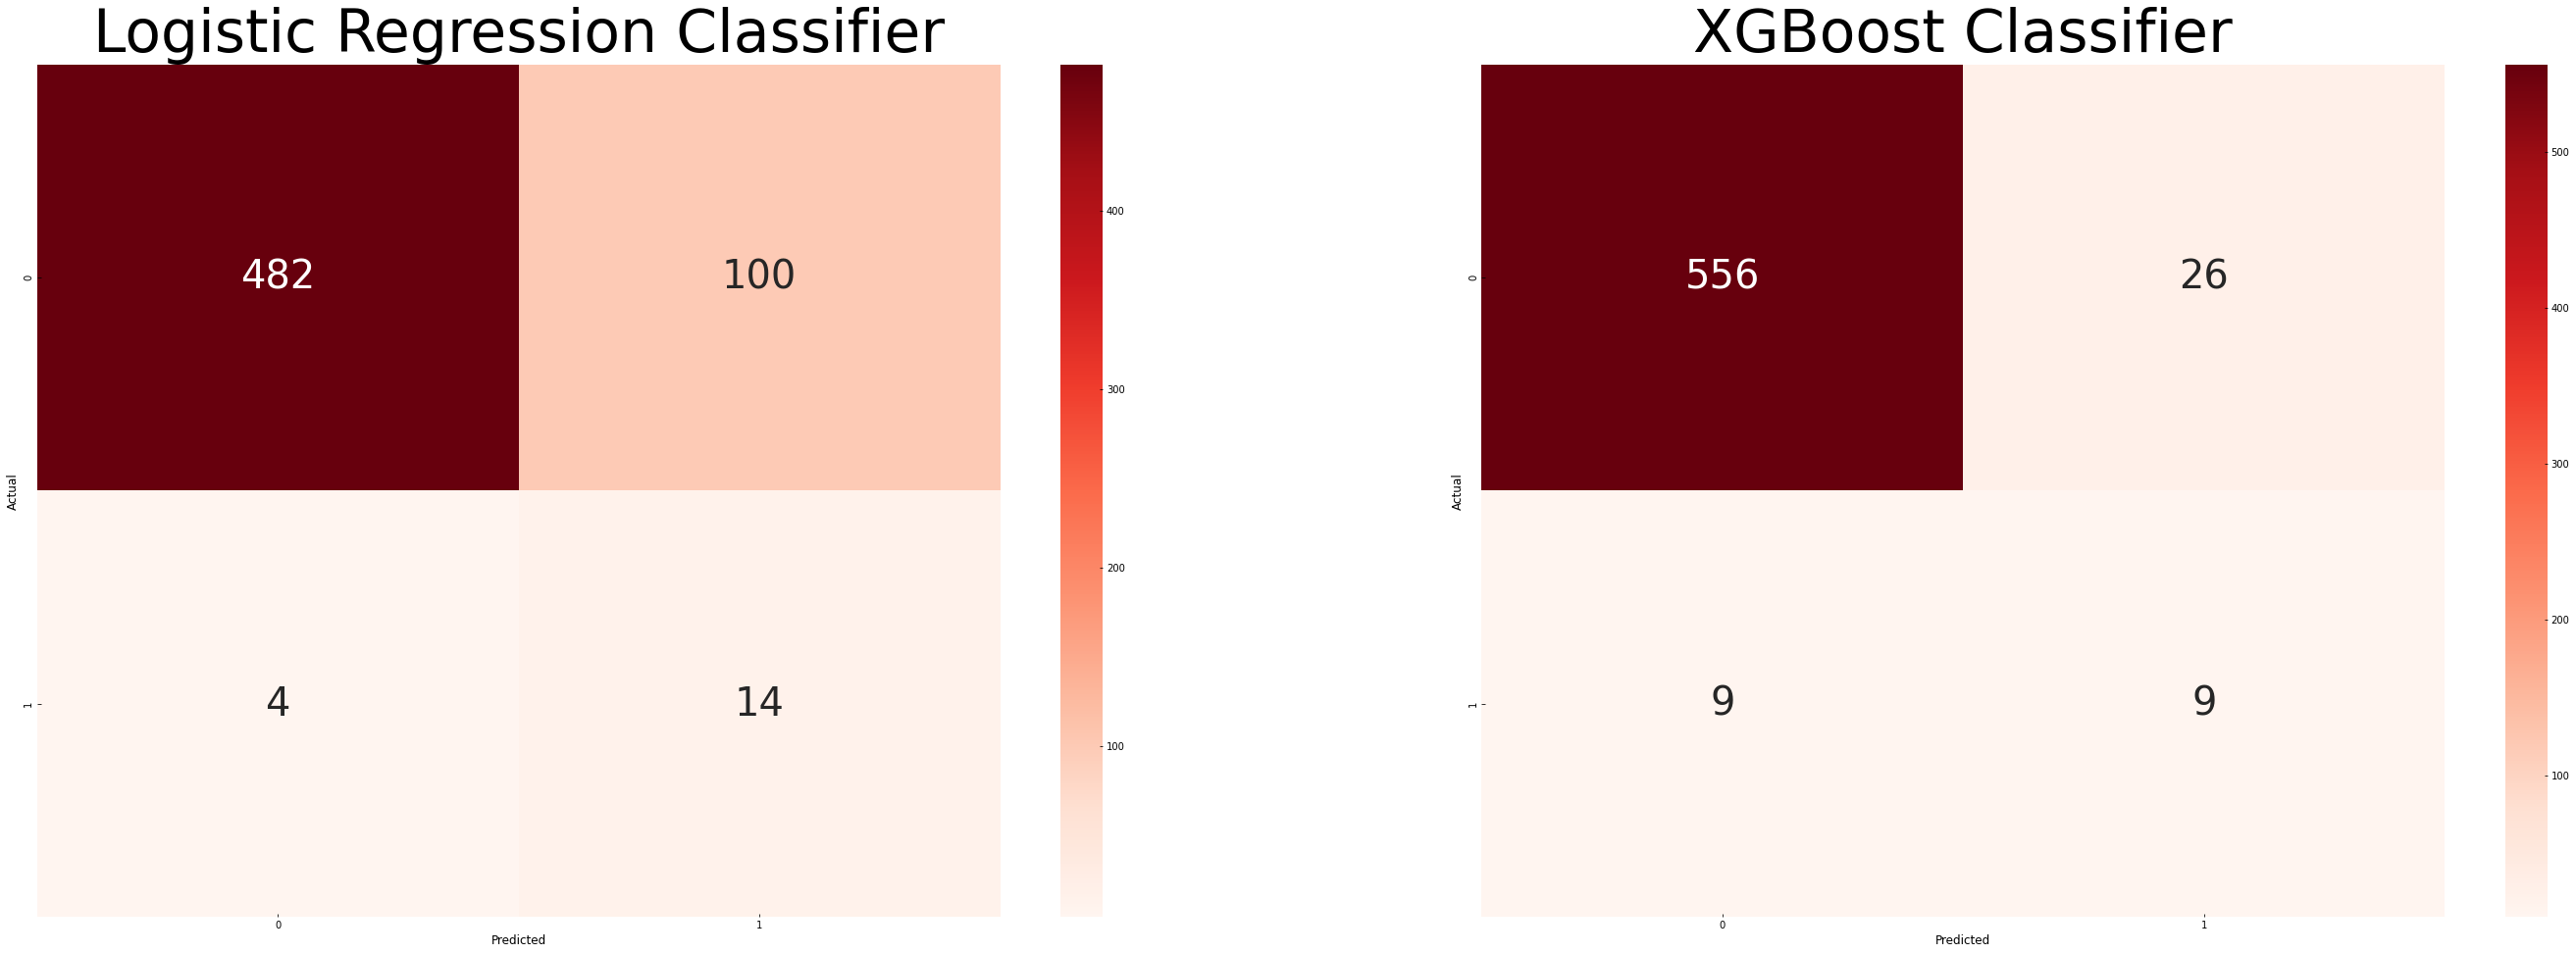

In [50]:
confusion_matrix_LR = confusion_matrix(y_test,test_prediction_LR)
confusion_matrix_XGB = confusion_matrix(y_test,test_prediction_XGB)

heat_confusion_matrix_LR = pd.DataFrame(confusion_matrix_LR, columns=np.unique(y_test), index = np.unique(y_test))
heat_confusion_matrix_LR.index.name = 'Actual'
heat_confusion_matrix_LR.columns.name = 'Predicted'

heat_confusion_matrix_XGB = pd.DataFrame(confusion_matrix_XGB, columns=np.unique(y_test), index = np.unique(y_test))
heat_confusion_matrix_XGB.index.name = 'Actual'
heat_confusion_matrix_XGB.columns.name = 'Predicted'

f, ax = plt.subplots(1, 2, figsize=(20,16))
f.subplots_adjust(left=None, bottom=None, right= 2, top=None, wspace=None, hspace= None)

sns.heatmap(heat_confusion_matrix_LR, cmap="Reds", annot=True, annot_kws={"size": 40},fmt='g', ax = ax[0])
ax[0].set_title('Logistic Regression Classifier', fontsize = 60)
sns.heatmap(heat_confusion_matrix_XGB, cmap="Reds", annot=True, annot_kws={"size": 40},fmt='g', ax = ax[1])
ax[1].set_title('XGBoost Classifier', fontsize = 60)

plt.show()

In [51]:
print('Logistic Regression report:\n')
print(classification_report(y_test, test_prediction_LR, target_names=label))

Logistic Regression report:

              precision    recall  f1-score   support

     Class 0       0.99      0.83      0.90       582
     Class 1       0.12      0.78      0.21        18

    accuracy                           0.83       600
   macro avg       0.56      0.80      0.56       600
weighted avg       0.97      0.83      0.88       600



In [52]:
print('XGBoost report:\n')
print(classification_report(y_test, test_prediction_XGB, target_names=label))

XGBoost report:

              precision    recall  f1-score   support

     Class 0       0.98      0.96      0.97       582
     Class 1       0.26      0.50      0.34        18

    accuracy                           0.94       600
   macro avg       0.62      0.73      0.65       600
weighted avg       0.96      0.94      0.95       600

